In [1]:
import awkward as ak
import numpy as np
import uproot as uproot
import matplotlib.pyplot as plt
import mplhep as hep
import vector as vec
from tqdm import tqdm
import ROOT
'''
from utils import *
from utilsPCA import *
from plotting import *
from efficiency import *
from isolation import *
'''
import matplotlib as mpl

#mpl.rc('xtick', labelsize=16) 
#mpl.rc('ytick', labelsize=16) 
#mpl.rc('axes', labelsize=16, titlesize=20)
#mpl.rcParams["legend.title_fontsize"]=18

#plt.style.use(hep.style.CMS)
%matplotlib inline

Welcome to JupyROOT 6.30/04


In [2]:
C = 29.9792458 #cm/ns

def distance(x1,y1,z1,x2,y2,z2):
    return ((x1-x2)**2+(y1-y2)**2+(z1-z2)**2)**0.5

In [3]:
# returns res that contains the parameters, the chi squared and 
# the counts and bins used to plot the data
def gauss_fit(data, init_parms, bins=300):
    hist, nbins = np.histogram(data, bins=bins)
    nbins = 0.5 * (bins[1:] + bins[:-1])
    errors = [np.sqrt(oh+1) for oh in hist]
    init_parameters = init_parms
    cost_func = cost.LeastSquares(nbins, hist, errors, model)
    min_obj = Minuit(cost_func, *init_parameters)
    res = min_obj.migrad()
    chi2 = min_obj.fval/(len(nbins[:-1])-3)
    return res, chi2, hist, nbins[:-1]

#same as above but plots also the data
def gauss_fit_and_plot(data, init_parms, label="data", colors=["midnightblue","dodgerblue"], bins=300):
    res, chi2, hists, newbins = gauss_fit(data, init_parms, bins=bins)
    y = model(newbins, *res.values)
    plt.plot(newbins, y, label=f'gauss fit\n   $\sigma$ = {res.values[2]:.3f} $\pm$ {res.errors[2]:.3f}\n   $x_0$ = {res.values[1]:.3f} $\pm$ {res.errors[1]:.3f} \n   $\chi^2_0$ = {chi2:.3f}', color=colors[0], linewidth=2)
    plt.hist(np.array(data), bins=bins, color=colors[1], alpha=0.7)
    plt.legend(fontsize=16)
    plt.grid()
    return res, chi2

In [4]:
# quick plot with list, np array or flattened awkward array
def myhist(X, bins=30, title='title', xlabel='time (ns)', ylabel='Counts / bin', color='dodgerblue', alpha=1, fill='stepfilled', range=None, label="data", density=False):
    #plt.figure(dpi=100)
    if range==None:
        plt.hist(np.array(X), bins=bins, color=color, alpha=alpha, histtype=fill, label=label, density=density)
    else:
        plt.hist(np.array(X), bins=bins, color=color, alpha=alpha, histtype=fill, range=range, label=label, density=density)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()  

In [5]:
def compute_barycenter_z(cluster_energy,cluster_z):
    mean_z=sum([a*b for a,b in zip(cluster_energy,cluster_z)])/sum(cluster_energy)
    return mean_z

def theta(x):
    if (x>=0):
        return 1.
    else:
        return -1.

In [6]:
def prop_to_bar(point, z_bar):
    # Define a line by its direction vector and a point on it
    line_dir = point # direction vector of the line
    line_pt = [0, 0, 0] # a point on the line

    # Define a plane by its normal vector and a point on it
    plane_norm = [0,0,1] # normal vector of the plane
    plane_pt = [0,0,z_bar] # a point on the plane

    # Compute the dot product of the line direction and the plane normal
    dot_prod = sum([a*b for a,b in zip(line_dir, plane_norm)])

    # Check if the dot product is zero, which means the line is parallel to the plane
    if dot_prod == 0:
        print("The line is parallel to the plane. No intersection point.")
        return [0,0,0]
    else:
        # Compute the parameter t that gives the intersection point
        t = sum([(a-b)*c for a,b,c in zip(plane_pt, line_pt, plane_norm)]) / dot_prod

        # Compute the intersection point by plugging t into the line equation
        inter_pt = [a + b*t for a,b in zip(line_pt, line_dir)]

        return inter_pt
    
prop_to_bar([0,0,1],-1)

[0.0, 0.0, -1.0]

In [21]:
filename = '/eos/user/t/tipaulet/CloseBy/CMSSW14_1_0_pre6/29693.203_CloseByParticleGun+2026D110_ticl_v5/histo.root' #histo_0PU_v5_time1hit
filename = "/eos/user/t/tipaulet/Tiziano/ParticleGunPion/histo/histo_SinglePi_0PU.root"
file = uproot.open(filename)

In [22]:
file.keys()

['ticlDumper;1',
 'ticlDumper/tracksters;1',
 'ticlDumper/clusters;1',
 'ticlDumper/candidates;1',
 'ticlDumper/trackstersMerged;1',
 'ticlDumper/associations;1',
 'ticlDumper/simtrackstersSC;1',
 'ticlDumper/simtrackstersCP;1',
 'ticlDumper/tracks;1',
 'ticlDumper/simTICLCandidate;1']

## File loading

In [23]:
# simhits = file["ticlDumper/simhits"]
f_candidates = file["ticlDumper/candidates;1"]

simcandidates = file["ticlDumper/simTICLCandidate;1"]

f_tracksters = file["ticlDumper/tracksters;1"]

f_tracks = file["ticlDumper/tracks;1"]

f_clusters = file["ticlDumper/clusters;1"]

f_trackstersMerged= file["ticlDumper/trackstersMerged;1"]

f_simtrackstersSC= file["ticlDumper/simtrackstersSC;1"]

f_simtrackstersCP= file["ticlDumper/simtrackstersCP;1"]

f_simTICLCandidate = file ["ticlDumper/simTICLCandidate;1"]

f_associations = file ["ticlDumper/associations;1"]

In [24]:
f_associations.keys()

print(f_associations["tsCLUE3D_simToReco_SC"].array())

[[[0, 1, 2, 3], [0, 1, 2, 3], [0, ... 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]]]


In [25]:
simcandidates.keys()

['simTICLCandidate_raw_energy',
 'simTICLCandidate_regressed_energy',
 'simTICLCandidate_simTracksterCPIndex',
 'simTICLCandidate_boundaryX',
 'simTICLCandidate_boundaryY',
 'simTICLCandidate_boundaryZ',
 'simTICLCandidate_boundaryPx',
 'simTICLCandidate_boundaryPy',
 'simTICLCandidate_boundaryPz',
 'simTICLCandidate_time',
 'simTICLCandidate_caloParticleMass',
 'simTICLCandidate_pdgId',
 'simTICLCandidate_charge',
 'simTICLCandidate_track_in_candidate']

In [26]:
f_tracks.keys()

['event',
 'track_id',
 'track_hgcal_x',
 'track_hgcal_y',
 'track_hgcal_z',
 'track_hgcal_eta',
 'track_hgcal_phi',
 'track_hgcal_pt',
 'track_pt',
 'track_missing_outer_hits',
 'track_missing_inner_hits',
 'track_quality',
 'track_charge',
 'track_time',
 'track_time_quality',
 'track_time_err',
 'track_beta',
 'track_time_mtd',
 'track_time_mtd_err',
 'track_pos_mtd',
 'track_pos_mtd/track_pos_mtd.theVector.theX',
 'track_pos_mtd/track_pos_mtd.theVector.theY',
 'track_pos_mtd/track_pos_mtd.theVector.theZ',
 'track_nhits',
 'track_isMuon',
 'track_isTrackerMuon']

In [27]:
f_candidates.keys()

['NCandidates',
 'candidate_charge',
 'candidate_pdgId',
 'candidate_id_probabilities',
 'candidate_time',
 'candidate_timeErr',
 'candidate_energy',
 'candidate_raw_energy',
 'candidate_px',
 'candidate_py',
 'candidate_pz',
 'track_in_candidate',
 'tracksters_in_candidate']

In [28]:
f_tracksters.keys()

['event',
 'NClusters',
 'NTracksters',
 'time',
 'timeError',
 'regressed_energy',
 'raw_energy',
 'raw_em_energy',
 'raw_pt',
 'raw_em_pt',
 'barycenter_x',
 'barycenter_y',
 'barycenter_z',
 'barycenter_eta',
 'barycenter_phi',
 'EV1',
 'EV2',
 'EV3',
 'eVector0_x',
 'eVector0_y',
 'eVector0_z',
 'sigmaPCA1',
 'sigmaPCA2',
 'sigmaPCA3',
 'id_probabilities',
 'vertices_indexes',
 'vertices_x',
 'vertices_y',
 'vertices_z',
 'vertices_time',
 'vertices_timeErr',
 'vertices_energy',
 'vertices_correctedEnergy',
 'vertices_correctedEnergyUncertainty',
 'vertices_multiplicity']

In [29]:
f_trackstersMerged.keys()

['event',
 'time',
 'timeError',
 'regressed_energy',
 'raw_energy',
 'raw_em_energy',
 'raw_pt',
 'raw_em_pt',
 'NTrackstersMerged',
 'barycenter_x',
 'barycenter_y',
 'barycenter_z',
 'barycenter_eta',
 'barycenter_phi',
 'EV1',
 'EV2',
 'EV3',
 'eVector0_x',
 'eVector0_y',
 'eVector0_z',
 'sigmaPCA1',
 'sigmaPCA2',
 'sigmaPCA3',
 'id_probabilities',
 'vertices_indexes',
 'vertices_x',
 'vertices_y',
 'vertices_z',
 'vertices_time',
 'vertices_timeErr',
 'vertices_energy',
 'vertices_correctedEnergy',
 'vertices_correctedEnergyUncertainty',
 'vertices_multiplicity']

In [30]:
f_clusters.keys()

['seedID',
 'energy',
 'correctedEnergy',
 'correctedEnergyUncertainty',
 'position_x',
 'position_y',
 'position_z',
 'position_eta',
 'position_phi',
 'cluster_layer_id',
 'cluster_type',
 'cluster_time',
 'cluster_timeErr',
 'cluster_number_of_hits']

cluster_time:  [[-99, -99, -99, -99, -99, -99, -99, -99, ... -99, -99, -99, -99, -99, -99, -99]]  len:  [[-99, -99, -99, -99, -99, -99, -99, -99, ... -99, -99, -99, -99, -99, -99, -99]]
cluster_type:  [[0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, ... 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6]]
n clusters:  [682, 855, 1298, 1621, 727, 426, 1204, 722, 1110, 1720] ...


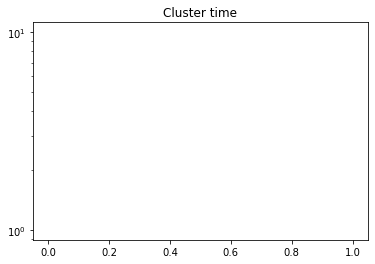

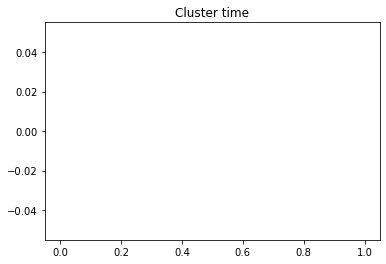

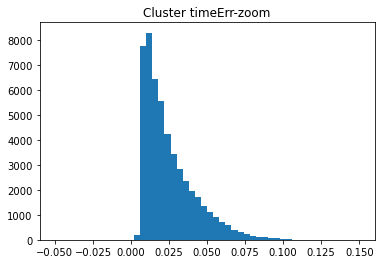

In [31]:
cluster_time = f_clusters["cluster_time"].array()
cluster_timeErr = f_clusters["cluster_timeErr"].array()
cluster_type=f_clusters["cluster_type"].array()
print("cluster_time: ",cluster_time, " len: ", cluster_time)
print("cluster_type: ", cluster_type)

n_clusters=[len(element) for element in cluster_time]
print("n clusters: ", n_clusters[0:10], "...")



#Nclusters = f_tracksters["NClusters"].array()

#print(Nclusters)

#Ntracksters = f_tracksters["NTracksters"].array()

#print(Nclusters)

plt.title("Cluster time")
plt.hist(np.ravel(cluster_time[(cluster_type==6) & (cluster_timeErr>0)]),bins=50, log=True)
plt.show() 
#print(n_candidates)

plt.title("Cluster time")
plt.hist(np.ravel(cluster_time[(cluster_type==6) & (cluster_timeErr>0)]),bins=50, log=False)
plt.show() 

plt.title("Cluster timeErr-zoom")
plt.hist(np.ravel(cluster_timeErr),bins=50,range=[-0.05,0.15])
plt.show() 


In [15]:
trackster_time = f_tracksters["time"].array()
bary_z=f_tracksters["barycenter_z"].array()

print(trackster_time)
print(bary_z[0],bary_z[1],bary_z[2],)
prob=f_tracksters["id_probabilities"].array()
print(prob)
print([len(x) for x in prob])

Nclusters = f_tracksters["NClusters"].array()

print(Nclusters)


Ntracksters = f_tracksters["NTracksters"].array()

print(type(Ntracksters))

Ntracksters.mean()

#print(n_candidates)

plt.title("trackster_time")
plt.hist(np.ravel(trackster_time),bins=50)
plt.show() 


plt.title("trackster_time")
plt.hist(np.ravel(trackster_time),bins=50, range=[7,20])
plt.show() 

[[11.2, 11.2, 11.2, 12], [11.7, 12.2, ... -99, -99, -99, -99, -99, -99, -99, -99]]
[-329, 328, 328, 350] [-336, -350, -351, -351, -356, -357, -358, ... 452, 474, 475, 475, 471, 492, 506] [-336, -343, -363, -354, -354, -365, -377, ... 413, 423, 425, 421, 431, 441, 443]
[[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ... 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0]]]
[4, 29, 49, 36, 13, 6, 20, 20, 33, 32, 18, 23, 16, 56, 55, 53, 26, 36, 26, 37, 10, 31, 27, 14, 31, 75, 37, 22, 19, 20, 22, 26, 27, 15, 23, 25, 21, 15, 23, 54, 24, 10, 25, 13, 21, 9, 17, 51, 66, 13, 16, 10, 10, 27, 35, 11, 9, 10, 51, 21, 10, 17, 22, 13, 11, 44, 19, 48, 13, 22, 6, 19, 50, 31, 17, 40, 18, 22, 21, 31, 35, 51, 25, 24, 31, 23, 27, 26, 13, 49, 9, 28, 42, 38, 33, 35, 28, 48, 12, 11, 11, 53, 37, 42, 55, 38, 24, 13, 39, 8, 5, 31, 29, 30, 31, 47, 15, 30, 38, 34, 27, 28, 24, 58, 56, 24, 6, 21, 10, 43, 35, 28, 11, 51, 13, 9, 62, 23, 16, 48, 22, 20, 14, 24, 48, 9, 28, 31, 16, 26, 27, 22, 22, 5, 56, 31, 20, 36, 17, 42, 20, 15, 10, 41, 7

AttributeError: no field named 'mean'

(https://github.com/scikit-hep/awkward-1.0/blob/1.10.3/src/awkward/highlevel.py#L1124)

[[[0.286, 0.379, 0.000131, 8.25e-05, 0.151, ... 0.486, 0.51, 3.32e-12, 3.52e-12]]]
[4, 12, 19, 14, 2, 3, 8, 7, 11, 18, 3, 15, 2, 25, 34, 16, 7, 14, 3, 4, 9, 19, 10, 7, 6, 34, 11, 11, 5, 6, 5, 9, 6, 10, 5, 11, 5, 10, 4, 25, 2, 5, 3, 4, 5, 2, 3, 24, 24, 4, 3, 4, 2, 4, 21, 8, 3, 3, 17, 7, 2, 3, 9, 3, 3, 18, 3, 17, 4, 14, 2, 6, 20, 5, 8, 13, 12, 9, 5, 19, 7, 13, 13, 5, 17, 7, 4, 8, 3, 11, 4, 7, 15, 11, 14, 15, 9, 15, 2, 5, 4, 24, 14, 15, 20, 9, 15, 4, 14, 3, 3, 8, 9, 9, 14, 7, 4, 13, 11, 8, 4, 7, 7, 17, 35, 10, 2, 6, 3, 16, 8, 9, 7, 19, 5, 3, 20, 11, 8, 22, 5, 12, 4, 4, 24, 3, 4, 10, 2, 13, 4, 4, 3, 2, 24, 10, 14, 8, 6, 10, 5, 8, 4, 17, 29, 2, 13, 7, 7, 11, 3, 4, 5, 2, 4, 14, 7, 9, 5, 15, 6, 8, 3, 11, 13, 24, 19, 8, 3, 11, 10, 12, 3, 6, 11, 6, 29, 36, 10, 11, 4, 5, 7, 34, 5, 10, 5, 12, 27, 9, 2, 5, 7, 23, 14, 8, 3, 11, 14, 15, 3, 19, 10, 8, 9, 14, 4, 2, 13, 7, 4, 8, 4, 3, 11, 5, 4, 14, 5, 3, 6, 2, 12, 12, 3, 3, 3, 3, 6, 10, 6, 2, 2, 10, 3, 14, 11, 5, 3, 4, 5, 12, 10, 15, 3, 9, 4, 8, 2, 4, 

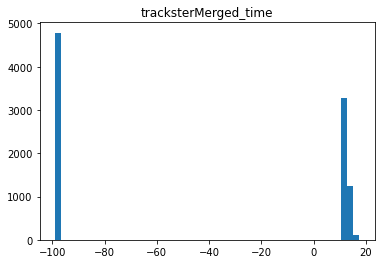

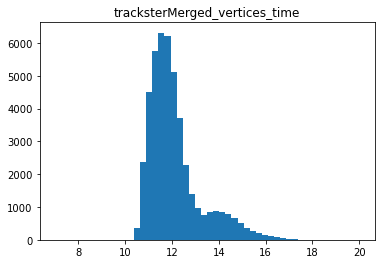

In [40]:
## Trackster merged

trackster_time = f_trackstersMerged["time"].array()
prob=f_trackstersMerged["id_probabilities"].array()
print(prob)
print([len(x) for x in prob])
trackster_vertextime = f_trackstersMerged["vertices_time"].array()

print(trackster_time, " len: ", len(trackster_time))

bary_z=f_trackstersMerged["barycenter_z"].array()

print(bary_z[0],bary_z[1],bary_z[2],)

#print(f_trackstersMerged["vertices_z"].array())
#Ntracksters = f_trackstersMerged["NTracksters"].array()

#print(Nclusters)


#print(n_candidates)

plt.title("tracksterMerged_time")
plt.hist(np.ravel(trackster_time),bins=50)
plt.show() 


plt.title("tracksterMerged_vertices_time")
plt.hist(np.ravel(trackster_vertextime),bins=50, range=[7,20])
plt.show() 

In [ ]:
track_time = f_tracks["track_time"].array()

print(track_time)

n_tracks=[len(element) for element in track_time]
print("n tracks: ", n_tracks[0:10], "...")

#Nclusters = f_tracksters["NClusters"].array()

#print(Nclusters)

#Ntracksters = f_tracksters["NTracksters"].array()

#print(Nclusters)

#print(n_candidates)

plt.title("track_time")
plt.hist(np.ravel(track_time),bins=50)
plt.show() 

In [ ]:
track_time = f_tracks["track_time_mtd"].array()
track_beta = f_tracks["track_beta"].array()

print("track_beta", track_beta)

print(track_time)

n_tracks=[len(element) for element in track_time]
print("n tracks: ", n_tracks[0:10], "...")

plt.title("track_time_mtd")
plt.hist(np.ravel(track_time),bins=50)
plt.show() 
#print(n_candidates)

plt.title("track_time_mtd")
plt.hist(np.ravel(track_time),bins=50, range=[9,11])
plt.show() 

In [ ]:
## TICL candidate

candidate_time = f_candidates["candidate_time"].array()
candidate_timeErr= f_candidates["candidate_timeErr"].array()

track_in_candidate=f_candidates["track_in_candidate"].array()
tracksters_in_candidate=f_candidates["tracksters_in_candidate"].array()

print("track in candidate:",  track_in_candidate)
print("tracksters in candidate: ", tracksters_in_candidate)
#candidate_time =f_candidates.arrays(f_candidates.keys())
print(candidate_time)

#n_candidates = n_candidates.arrays(n_candidates.keys())
#n_candidates=candidates["NCandidates"].array()
#print(candidate_time)
#print(n_candidates)
#n_candidates=[]
n_candidates=[len(element) for element in candidate_time]
#print(len(n_candidates))
#print(len(candidate_time))

#print(n_candidates)

plt.title("TICL candidate time")
plt.hist(np.ravel(candidate_time),bins=50)
plt.show() 

In [ ]:
## Simulated 




#print(f_simTICLCandidate.keys())





candidate_time = f_simTICLCandidate["simTICLCandidate_time"].array()




print(candidate_time)


n_candidates=[len(element) for element in candidate_time]


plt.title("Simulated TICL candidate time")
plt.hist(np.ravel(candidate_time),bins=50)
plt.show() 





In [ ]:

f_simtrackstersSC.keys()



simtrackster_time = f_simtrackstersSC["time"].array()

simtrackster_timerr = f_simtrackstersSC["timeError"].array()

print(simtrackster_time, " len: ", len(simtrackster_time))

#print(f_trackstersMerged["vertices_z"].array())
#Ntracksters = f_trackstersMerged["NTracksters"].array()

#print(Nclusters)


#print(n_candidates)

plt.title("simtrackster_time")
plt.hist(np.ravel(simtrackster_time),bins=50,range=[8,16])
plt.show() 


plt.title("simtrackster_timerr")
plt.hist(np.ravel(simtrackster_timerr),bins=50, range=[0,0.1])
plt.show() 






In [ ]:
print(f_trackstersMerged.keys())


vertices_time=f_trackstersMerged["vertices_time"].array()
vertices_indexes=f_trackstersMerged["vertices_indexes"].array()

print(vertices_time)

print(vertices_indexes)
print([len(x) for x in vertices_time])




print(f_clusters["cluster_time"].array())
print(f_clusters["cluster_layer_id"].array())
cluster_time=f_clusters["cluster_time"].array()
cluster_energy=f_clusters["energy"].array()
print("cl_energy", type(cluster_energy))
n_elem= [len(x) for x in cluster_time]

#print("n_elem: ", n_elem)

time_residuals=[]
'''
good=0
notgood=0
for i in range(len(n_elem)):
    
    for j in range(len(cluster_time[i])):
        if cluster_time[i][j]!=-99:
            good+=1
        else:
            notgood+=1

print("with time", good)
print("without time:", notgood)
print("percentage of clusters with time", good/(good+notgood))
'''
mask=(cluster_time!=-99)
print(mask)
#idx_w_time=ak.where(cluster_time!=-99)
cluster_time_clean=cluster_time[mask]

cluster_energy_clean=cluster_energy[mask]

cluster_time=cluster_time_clean
cluster_energy=cluster_energy_clean


for i in range(len(n_elem)):
    sorted_energies=ak.sort(cluster_energy[i],ascending=False)
    k=0
    index=ak.where(cluster_energy[i]==sorted_energies[k])[0]
    while cluster_time[i][index][0]==-99:
        k+=1
        index=ak.where(cluster_energy[i]==sorted_energies[k])[0]
    
    max_energy=cluster_energy[i][index]
    index_max_energy= index
    
    
    for j in range(len(cluster_time[i])):
        if cluster_time[i][j]!=-99:
            time_residuals.append(cluster_time[i][index_max_energy]-cluster_time[i][j])
        








plt.title("time_residuals")
plt.hist(time_residuals,bins=50)#, range=[0,0.1])
plt.show() 





# All clusters, not projected

['seedID', 'energy', 'correctedEnergy', 'correctedEnergyUncertainty', 'position_x', 'position_y', 'position_z', 'position_eta', 'position_phi', 'cluster_layer_id', 'cluster_type', 'cluster_time', 'cluster_timeErr', 'cluster_number_of_hits']
[[-99, -99, -99, -99, -99, -99, -99, -99, ... -99, -99, -99, -99, -99, -99, -99]]
[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 43, 44, 45, 46, 47, 44, 46, 46, 47, 47, 38]]
cl_energy <class 'awkward.highlevel.Array'>
[[False, False, False, False, False, False, ... False, False, False, False, False]]
[682, 855, 1298, 1621, 727, 426, 1204, 722, 1110, 1720, 684, 1133, 401, 1696, 2273, 772, 828, 1319, 1453, 1097, 978, 1841, 1596, 928, 1061, 2201, 750, 1222, 871, 804, 1095, 943, 567, 758, 555, 1628, 756, 1117, 692, 1317, 842, 713, 836, 657, 691, 479, 399, 2086, 1932, 340, 575, 639, 342, 1175, 1291, 701, 759, 725, 1722, 526, 326, 666, 1297, 538, 706, 1140, 545, 1844, 634, 1335, 353, 720, 903, 1136, 857, 2484, 1037, 1078, 976, 1718, 1185, 2205, 838, 470, 970, 506

100%|██████████| 1000/1000 [02:30<00:00,  6.65it/s]


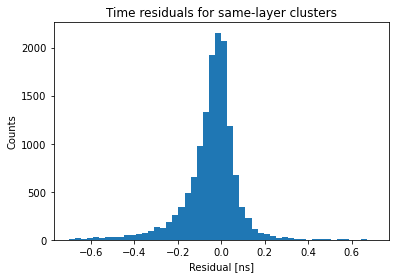

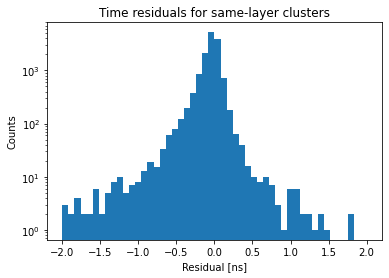

Warning in <TROOT::Append>: Replacing existing TH1: t_res (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: t_res_sigma (Potential memory leak).
Info in <TCanvas::Print>: png file h2.png has been created
Info in <TCanvas::Print>: png file h2_log.png has been created
Info in <TCanvas::Print>: png file h2_sigma.png has been created
Info in <TCanvas::Print>: png file h2_sigma_log.png has been created


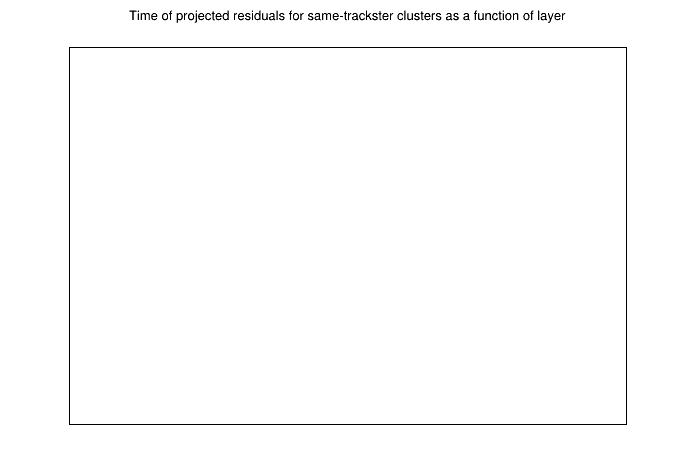

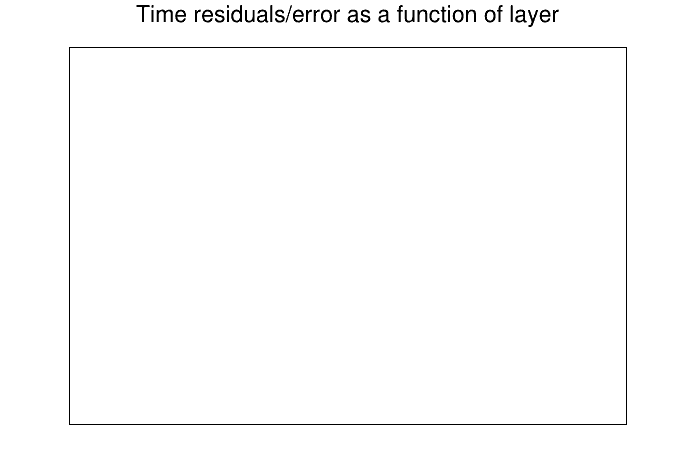

In [17]:
print(f_clusters.keys())

print(f_clusters["cluster_time"].array())
print(f_clusters["cluster_layer_id"].array())
cluster_time=f_clusters["cluster_time"].array()
cluster_energy=f_clusters["energy"].array()
cluster_layer=f_clusters["cluster_layer_id"].array()
cluster_z=f_clusters['position_z'].array()
cluster_time_error=f_clusters["cluster_timeErr"].array()



print("cl_energy", type(cluster_energy))
n_elem= [len(x) for x in cluster_time]

#print("n_elem: ", n_elem)

time_residuals=[]
'''
good=0
notgood=0
for i in range(len(n_elem)):
    
    for j in range(len(cluster_time[i])):
        if cluster_time[i][j]!=-99:
            good+=1
        else:
            notgood+=1

print("with time", good)
print("without time:", notgood)
print("percentage of clusters with time", good/(good+notgood))
'''
times_list=[]
nlayers=47
for i in range(nlayers):
    times_list.append([])

mask=(cluster_time!=-99)
print(mask)

ntimes=[len(x) for x in cluster_time]
print(ntimes)

cluster_time_clean=cluster_time[mask]
cluster_time_error_clean=cluster_time_error[mask]
cluster_energy_clean=cluster_energy[mask]
cluster_layer_clean=cluster_layer[mask]
cluster_z_clean=cluster_z[mask]
print(len(cluster_time_clean))
ntimes=[len(x) for x in cluster_time_clean]
print(ntimes)
nlayers=47
res_layer=ROOT.TH2F("t_res","Time residuals as a function of layer;Residual [ns];Layer",50,-1.,1.,nlayers,0.5,nlayers+0.5)
res_layer_sigma=ROOT.TH2F("t_res_sigma","Time residuals/error as a function of layer;Residual ;Layer",50,-3.,3.,nlayers,0.5,nlayers+0.5)

for i in tqdm(range(len(cluster_time_clean))):
    for side in [-1.,1.]:
        mask_side=(side*cluster_z_clean[i]>0)
        cluster_layer_side=cluster_layer_clean[i][mask_side]
        cluster_time_side=cluster_time_clean[i][mask_side]
        cluster_time_error_side=cluster_time_error_clean[i][mask_side]
        
        cluster_energy_side=cluster_energy_clean[i][mask_side]
        
        for layer in range(nlayers):
            mask_layer=(cluster_layer_side==layer)
            cluster_time_layer=cluster_time_side[mask_layer]
            cluster_time_error_layer=cluster_time_error_side[mask_layer]
            cluster_energy_layer=cluster_energy_side[mask_layer]
            if(len(cluster_energy_layer))>0:
                max_idx=ak.argmax(cluster_energy_layer)
                for j in range(len(cluster_energy_layer)):
                    if j!=max_idx:
                        time_residuals.append(cluster_time_layer[max_idx]-cluster_time_layer[j])
                        res_layer.Fill(cluster_time_layer[max_idx]-cluster_time_layer[j],layer)
                        res_layer_sigma.Fill((cluster_time_layer[max_idx]-cluster_time_layer[j])/(cluster_time_error_layer[max_idx]**2+cluster_time_error_layer[j]**2)**0.5,layer)
                        

            
'''
for i in range(len(n_elem)):
    for j in range(len(cluster_time[i])):
        if cluster_time[i][j]!=-99:
            times_list[i].append(cluster_time[i][j])
    

for i in range(len(n_elem)):
    sorted_energies=ak.sort(cluster_energy[i],ascending=False)
    k=0
    index=ak.where(cluster_energy[i]==sorted_energies[k])[0]
    while cluster_time[i][index][0]==-99:
        k+=1
        index=ak.where(cluster_energy[i]==sorted_energies[k])[0]
    
    max_energy=cluster_energy[i][index]
    index_max_energy= index
    
    
    for j in range(len(cluster_time[i])):
        if cluster_time[i][j]!=-99:
            time_residuals.append(cluster_time[i][index_max_energy]-cluster_time[i][j])
            
'''

ROOT.gStyle.SetOptStat(11);

c1=ROOT.TCanvas()
c1.cd()
res_layer.Draw("COLZ")
c1.SaveAs("h2.png")
c1.Draw()

c1.SetLogz()
c1.Draw()
c1.SaveAs("h2_log.png")

c2=ROOT.TCanvas()
c2.cd()
res_layer_sigma.Draw("COLZ")
c2.SaveAs("h2_sigma.png")
c2.Draw()

c2.SetLogz()
c2.Draw()
c2.SaveAs("h2_sigma_log.png")



plt.title("Time residuals for same-layer clusters")
plt.xlabel("Residual [ns]")
plt.ylabel("Counts")
plt.hist(time_residuals,bins=50, range=[-0.7,0.7])

plt.savefig('h1.pdf')  
plt.show() 

plt.title("Time residuals for same-layer clusters")
plt.xlabel("Residual [ns]")
plt.ylabel("Counts")


plt.hist(time_residuals,bins=50,log=True,range=[-2,2])#, range=[0,0.1])
plt.savefig('h1_log.pdf')  

plt.show() 


#To do, mostrare residui in funzione di sigma
#To do, mostrare distribuzione dei tempi dei layer cluster proiettati
#Distinguere tra parte upstream e downstream del calorimetro


# Projected, all clusters

['seedID', 'energy', 'correctedEnergy', 'correctedEnergyUncertainty', 'position_x', 'position_y', 'position_z', 'position_eta', 'position_phi', 'cluster_layer_id', 'cluster_type', 'cluster_time', 'cluster_timeErr', 'cluster_number_of_hits']
[[-99, -99, -99, -99, -99, -99, -99, -99, ... -99, -99, -99, -99, -99, -99, -99]]
[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 43, 44, 45, 46, 47, 44, 46, 46, 47, 47, 38]]
cl_energy <class 'awkward.highlevel.Array'>
[[False, False, False, False, False, False, ... False, False, False, False, False]]
[682, 855, 1298, 1621, 727, 426, 1204, 722, 1110, 1720, 684, 1133, 401, 1696, 2273, 772, 828, 1319, 1453, 1097, 978, 1841, 1596, 928, 1061, 2201, 750, 1222, 871, 804, 1095, 943, 567, 758, 555, 1628, 756, 1117, 692, 1317, 842, 713, 836, 657, 691, 479, 399, 2086, 1932, 340, 575, 639, 342, 1175, 1291, 701, 759, 725, 1722, 526, 326, 666, 1297, 538, 706, 1140, 545, 1844, 634, 1335, 353, 720, 903, 1136, 857, 2484, 1037, 1078, 976, 1718, 1185, 2205, 838, 470, 970, 506

100%|██████████| 1000/1000 [02:59<00:00,  5.58it/s]


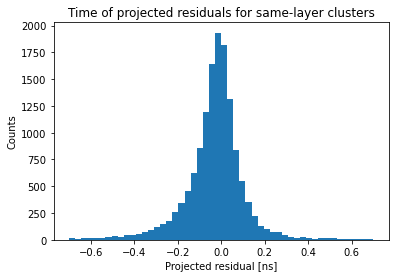

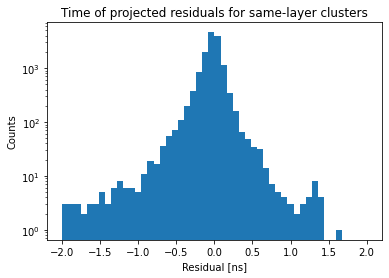

Info in <TCanvas::Print>: png file h2_proj.png has been created
Info in <TCanvas::Print>: png file h2_proj_log.png has been created


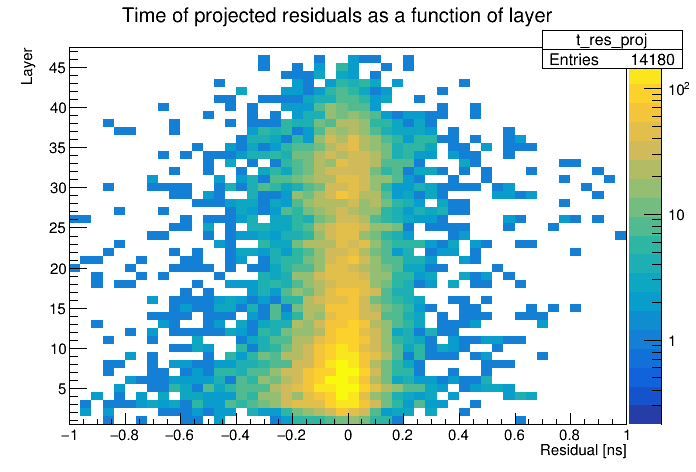

In [15]:
print(f_clusters.keys())

print(f_clusters["cluster_time"].array())
print(f_clusters["cluster_layer_id"].array())
cluster_time=f_clusters["cluster_time"].array()
cluster_energy=f_clusters["correctedEnergy"].array()
cluster_layer=f_clusters["cluster_layer_id"].array()
cluster_x=f_clusters['position_x'].array()
cluster_y=f_clusters['position_y'].array()
cluster_z=f_clusters['position_z'].array()
cluster_time_error=f_clusters["cluster_timeErr"].array()



print("cl_energy", type(cluster_energy))
n_elem= [len(x) for x in cluster_time]

#print("n_elem: ", n_elem)

time_residuals=[]
'''
good=0
notgood=0
for i in range(len(n_elem)):
    
    for j in range(len(cluster_time[i])):
        if cluster_time[i][j]!=-99:
            good+=1
        else:
            notgood+=1

print("with time", good)
print("without time:", notgood)
print("percentage of clusters with time", good/(good+notgood))
'''
times_list=[]
nlayers=47
for i in range(nlayers):
    times_list.append([])

mask=(cluster_time!=-99)
print(mask)

ntimes=[len(x) for x in cluster_time]
print(ntimes)

cluster_time_clean=cluster_time[mask]
cluster_time_error_clean=cluster_time_error[mask]
cluster_energy_clean=cluster_energy[mask]
cluster_layer_clean=cluster_layer[mask]
cluster_x_clean=cluster_x[mask]
cluster_y_clean=cluster_y[mask]
cluster_z_clean=cluster_z[mask]
print(len(cluster_time_clean))
ntimes=[len(x) for x in cluster_time_clean]
print(ntimes)
nlayers=47

file = ROOT.TFile.Open("Plots/plots_proj.root", "RECREATE")

res_layer=ROOT.TH2F("t_res_proj","Time of projected residuals as a function of layer;Residual [ns];Layer",50,-1.,1.,nlayers,0.5,nlayers+0.5)
res_layer_sigma=ROOT.TH2F("t_res_sigma","Time residuals/error as a function of layer;Residual ;Layer",50,-3.,3.,nlayers,0.5,nlayers+0.5)

#mask_neg=(cluster_energy>100)
#print(cluster_energy[mask_neg])    
for i in tqdm(range(len(cluster_time_clean))):
    for side in [-1.,1.]:
        mask_side_all=(side*cluster_z[i]>0)
        barycenter_z=compute_barycenter_z(cluster_energy[i][mask_side_all],cluster_z[i][mask_side_all])
        #print(barycenter_z)
        mask_side=(side*cluster_z_clean[i]>0)
        cluster_layer_side=cluster_layer_clean[i][mask_side]
        cluster_time_side=cluster_time_clean[i][mask_side]
        cluster_time_error_side=cluster_time_error_clean[i][mask_side]
        cluster_x_side=cluster_x_clean[i][mask_side]
        cluster_y_side=cluster_y_clean[i][mask_side]
        cluster_z_side=cluster_z_clean[i][mask_side]
        cluster_energy_side=cluster_energy_clean[i][mask_side]
        
        for layer in range(nlayers):
            mask_layer=(cluster_layer_side==layer)
            cluster_time_layer=cluster_time_side[mask_layer]
            cluster_time_error_layer=cluster_time_error_side[mask_layer]
            cluster_energy_layer=cluster_energy_side[mask_layer]
            
            cluster_x_layer=cluster_x_side[mask_layer]
            cluster_y_layer=cluster_y_side[mask_layer]
            cluster_z_layer=cluster_z_side[mask_layer]
            
            if(len(cluster_energy_layer))>0:
                max_idx=ak.argmax(cluster_energy_layer)
                for j in range(len(cluster_energy_layer)):
                    if j!=max_idx:
                        proj_pos_max=prop_to_bar([cluster_x_layer[max_idx],cluster_y_layer[max_idx],cluster_z_layer[max_idx]], barycenter_z)
                        proj_time_max=cluster_time_layer[max_idx]+side*theta(barycenter_z-cluster_z_layer[max_idx])*distance(proj_pos_max[0],proj_pos_max[1],proj_pos_max[2],cluster_x_layer[max_idx],cluster_y_layer[max_idx],cluster_z_layer[max_idx])/C
                        #print(side*theta(barycenter_z-cluster_z_layer[max_idx])*distance(proj_pos_max[0],proj_pos_max[1],proj_pos_max[2],cluster_x_layer[max_idx],cluster_y_layer[max_idx],cluster_z_layer[max_idx])/C)
                        
                        proj_pos_j=prop_to_bar([cluster_x_layer[j],cluster_y_layer[j],cluster_z_layer[j]], barycenter_z)
                        proj_time_j=cluster_time_layer[j]+side*theta(barycenter_z-cluster_z_layer[j])*distance(proj_pos_j[0],proj_pos_j[1],proj_pos_j[2],cluster_x_layer[j],cluster_y_layer[j],cluster_z_layer[j])/C
                        #print(side*theta(barycenter_z-cluster_z_layer[j])*distance(proj_pos_j[0],proj_pos_j[1],proj_pos_j[2],cluster_x_layer[j],cluster_y_layer[j],cluster_z_layer[j])/C)
                        
                        time_residuals.append(proj_time_max-proj_time_j)
                        res_layer.Fill(proj_time_max-proj_time_j,layer)
                        #res_layer_sigma.Fill((cluster_time_layer[max_idx]-cluster_time_layer[j])/(cluster_time_error_layer[max_idx]**2+cluster_time_error_layer[j]**2)**0.5,layer)
                        

            
'''
for i in range(len(n_elem)):
    for j in range(len(cluster_time[i])):
        if cluster_time[i][j]!=-99:
            times_list[i].append(cluster_time[i][j])
    

for i in range(len(n_elem)):
    sorted_energies=ak.sort(cluster_energy[i],ascending=False)
    k=0
    index=ak.where(cluster_energy[i]==sorted_energies[k])[0]
    while cluster_time[i][index][0]==-99:
        k+=1
        index=ak.where(cluster_energy[i]==sorted_energies[k])[0]
    
    max_energy=cluster_energy[i][index]
    index_max_energy= index
    
    
    for j in range(len(cluster_time[i])):
        if cluster_time[i][j]!=-99:
            time_residuals.append(cluster_time[i][index_max_energy]-cluster_time[i][j])
            
'''

ROOT.gStyle.SetOptStat(11);

c1=ROOT.TCanvas()
c1.cd()
res_layer.Draw("COLZ")
c1.SaveAs("h2_proj.png")
c1.Draw()

c1.SetLogz()
c1.Draw()
c1.SaveAs("h2_proj_log.png")

'''
c2=ROOT.TCanvas()
c2.cd()
res_layer_sigma.Draw("COLZ")
c2.SaveAs("h2_sigma.png")
c2.Draw()

c2.SetLogz()
c2.Draw()
c2.SaveAs("h2_sigma_log.png")
'''


plt.title("Time of projected residuals for same-layer clusters")
plt.xlabel("Projected residual [ns]")
plt.ylabel("Counts")
plt.hist(time_residuals,bins=50, range=[-0.7,0.7])

plt.savefig('h1_proj.pdf')  
plt.show() 

plt.title("Time of projected residuals for same-layer clusters")
plt.xlabel("Residual [ns]")
plt.ylabel("Counts")


plt.hist(time_residuals,bins=50,log=True,range=[-2,2])#, range=[0,0.1])
plt.savefig('h1_proj_log.pdf')  

plt.show() 

# Within tracksters

['seedID', 'energy', 'correctedEnergy', 'correctedEnergyUncertainty', 'position_x', 'position_y', 'position_z', 'position_eta', 'position_phi', 'cluster_layer_id', 'cluster_type', 'cluster_time', 'cluster_timeErr', 'cluster_number_of_hits']
['event', 'time', 'timeError', 'regressed_energy', 'raw_energy', 'raw_em_energy', 'raw_pt', 'raw_em_pt', 'NTrackstersMerged', 'barycenter_x', 'barycenter_y', 'barycenter_z', 'barycenter_eta', 'barycenter_phi', 'EV1', 'EV2', 'EV3', 'eVector0_x', 'eVector0_y', 'eVector0_z', 'sigmaPCA1', 'sigmaPCA2', 'sigmaPCA3', 'id_probabilities', 'vertices_indexes', 'vertices_x', 'vertices_y', 'vertices_z', 'vertices_time', 'vertices_timeErr', 'vertices_energy', 'vertices_correctedEnergy', 'vertices_correctedEnergyUncertainty', 'vertices_multiplicity']
[[[11, 11, 11, 11, 11.1, 11.2, 11.1, 11.2, -99, ... -99, -99], [-99, -99, -99, -99]]]
[[336, 340, 344, 348, 362, 367, 371, 384, ... 546, 556, 570, 583, 607, 619, 622]]
[4, 12, 19, 14, 2, 3, 8, 7, 11, 18, 3, 15, 2, 25,

100%|██████████| 1000/1000 [40:48<00:00,  2.45s/it] 


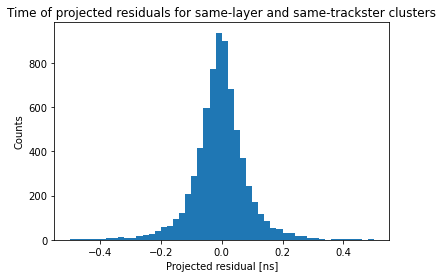

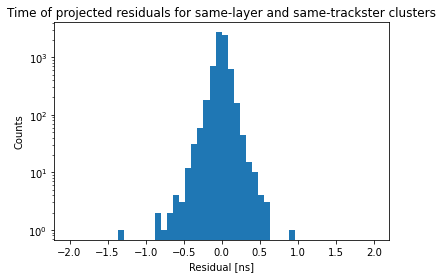

Info in <TCanvas::Print>: png file Plots/h2_proj_trackster.png has been created
Info in <TCanvas::Print>: pdf file Plots/h2_proj_trackster.pdf has been created
Info in <TCanvas::Print>: png file Plots/h2_proj_log_trackster.png has been created
Info in <TCanvas::Print>: pdf file Plots/h2_proj_log_trackster.pdf has been created


In [18]:
print(f_clusters.keys())

print(f_trackstersMerged.keys())


vertices_time=f_trackstersMerged["vertices_time"].array()
vertices_indexes=f_trackstersMerged["vertices_indexes"].array()

print(vertices_time)

print(vertices_indexes[0])

print([len(x) for x in vertices_time])




print(f_clusters["cluster_time"].array())
print(f_clusters["cluster_layer_id"].array())


cluster_time=f_clusters["cluster_time"].array()
cluster_energy=f_clusters["correctedEnergy"].array()
cluster_layer=f_clusters["cluster_layer_id"].array()
cluster_x=f_clusters['position_x'].array()
cluster_y=f_clusters['position_y'].array()
cluster_z=f_clusters['position_z'].array()
cluster_time_error=f_clusters["cluster_timeErr"].array()



print("cl_energy", type(cluster_energy))
n_elem= [len(x) for x in cluster_time]

#print("n_elem: ", n_elem)

time_residuals_proj=[]

'''
good=0
notgood=0
for i in range(len(n_elem)):
    
    for j in range(len(cluster_time[i])):
        if cluster_time[i][j]!=-99:
            good+=1
        else:
            notgood+=1

print("with time", good)
print("without time:", notgood)
print("percentage of clusters with time", good/(good+notgood))
'''
times_list=[]
nlayers=47
for i in range(nlayers):
    times_list.append([])

mask=(cluster_time!=-99)
#print(mask)

#ntimes=[len(x) for x in cluster_time]
#print("number of clusters:", ntimes)

cluster_time_clean=cluster_time[mask]
cluster_time_error_clean=cluster_time_error[mask]
cluster_energy_clean=cluster_energy[mask]
cluster_layer_clean=cluster_layer[mask]
cluster_x_clean=cluster_x[mask]
cluster_y_clean=cluster_y[mask]
cluster_z_clean=cluster_z[mask]
#print(len(cluster_time_clean))
#ntimes=[len(x) for x in cluster_time_clean]
#print(ntimes)
nlayers=47

file = ROOT.TFile.Open("Plots/plots_proj.root", "RECREATE")


res_layer=ROOT.TH2F("t_res_proj","Time of projected residuals for same-layer and same-trackster clusters as a function of layer;Residual [ns];Layer",50,-1.,1.,nlayers,0.5,nlayers+0.5)
res_layer_sigma=ROOT.TH2F("t_res_sigma","Time residuals/error as a function of layer;Residual ;Layer",50,-3.,3.,nlayers,0.5,nlayers+0.5)

#mask_neg=(cluster_energy>100)
#print(cluster_energy[mask_neg])    

for i in tqdm(range(len(vertices_indexes))):
    for k in range(len(vertices_indexes[i])):
        mask_trackster=np.full((len(cluster_time[i])), False)
        for l in range(len(vertices_indexes[i][k])):
            mask_trackster[vertices_indexes[i][k][l]]=True
            
            
            
        mask_trackster=ak.Array(mask_trackster)
        #print(len(mask[i]), len(mask_trackster))
        mask_trackster_1=mask[i] & mask_trackster
        cluster_time_trackster=cluster_time[i][mask_trackster_1]
        cluster_time_error_trackster=cluster_time_error[i][mask_trackster_1]
        cluster_energy_trackster=cluster_energy[i][mask_trackster_1]
        cluster_layer_trackster=cluster_layer[i][mask_trackster_1]
        cluster_x_trackster=cluster_x[i][mask_trackster_1]
        cluster_y_trackster=cluster_y[i][mask_trackster_1]
        cluster_z_trackster=cluster_z[i][mask_trackster_1]
        
        
        
        
        for side in [-1.,1.]:
            mask_side_all=(side*cluster_z[i]>0)
            barycenter_z=compute_barycenter_z(cluster_energy[i][mask_side_all],cluster_z[i][mask_side_all])
            #print(barycenter_z)
            mask_side=(side*cluster_z_trackster>0)
            cluster_layer_side=cluster_layer_trackster[mask_side]
            cluster_time_side=cluster_time_trackster[mask_side]
            cluster_time_error_side=cluster_time_error_trackster[mask_side]
            cluster_x_side=cluster_x_trackster[mask_side]
            cluster_y_side=cluster_y_trackster[mask_side]
            cluster_z_side=cluster_z_trackster[mask_side]
            cluster_energy_side=cluster_energy_trackster[mask_side]
        
            for layer in range(nlayers):
                mask_layer=(cluster_layer_side==layer)
                cluster_time_layer=cluster_time_side[mask_layer]
                cluster_time_error_layer=cluster_time_error_side[mask_layer]
                cluster_energy_layer=cluster_energy_side[mask_layer]

                cluster_x_layer=cluster_x_side[mask_layer]
                cluster_y_layer=cluster_y_side[mask_layer]
                cluster_z_layer=cluster_z_side[mask_layer]

                if(len(cluster_energy_layer))>0:
                    max_idx=ak.argmax(cluster_energy_layer)
                    for j in range(len(cluster_energy_layer)):
                        if j!=max_idx:
                            proj_pos_max=prop_to_bar([cluster_x_layer[max_idx],cluster_y_layer[max_idx],cluster_z_layer[max_idx]], barycenter_z)
                            proj_time_max=cluster_time_layer[max_idx]+side*theta(barycenter_z-cluster_z_layer[max_idx])*distance(proj_pos_max[0],proj_pos_max[1],proj_pos_max[2],cluster_x_layer[max_idx],cluster_y_layer[max_idx],cluster_z_layer[max_idx])/C
                            #print(side*theta(barycenter_z-cluster_z_layer[max_idx])*distance(proj_pos_max[0],proj_pos_max[1],proj_pos_max[2],cluster_x_layer[max_idx],cluster_y_layer[max_idx],cluster_z_layer[max_idx])/C)

                            proj_pos_j=prop_to_bar([cluster_x_layer[j],cluster_y_layer[j],cluster_z_layer[j]], barycenter_z)
                            proj_time_j=cluster_time_layer[j]+side*theta(barycenter_z-cluster_z_layer[j])*distance(proj_pos_j[0],proj_pos_j[1],proj_pos_j[2],cluster_x_layer[j],cluster_y_layer[j],cluster_z_layer[j])/C
                            #print(side*theta(barycenter_z-cluster_z_layer[j])*distance(proj_pos_j[0],proj_pos_j[1],proj_pos_j[2],cluster_x_layer[j],cluster_y_layer[j],cluster_z_layer[j])/C)

                            time_residuals_proj.append(proj_time_max-proj_time_j)
                            res_layer.Fill(proj_time_max-proj_time_j,layer)
                            #res_layer_sigma.Fill((cluster_time_layer[max_idx]-cluster_time_layer[j])/(cluster_time_error_layer[max_idx]**2+cluster_time_error_layer[j]**2)**0.5,layer)



ROOT.gStyle.SetOptStat(11);

c1=ROOT.TCanvas()
c1.cd()
res_layer.Draw("COLZ")
c1.SaveAs("Plots/h2_proj_trackster.png")
c1.SaveAs("Plots/h2_proj_trackster.pdf")

c1.Draw()

c1.SetLogz()
c1.Draw()
c1.SaveAs("Plots/h2_proj_log_trackster.png")

c1.SaveAs("Plots/h2_proj_log_trackster.pdf")


c1.Write()
res_layer.Write()
file.Close()

'''
c2=ROOT.TCanvas()
c2.cd()
res_layer_sigma.Draw("COLZ")
c2.SaveAs("h2_sigma.png")
c2.Draw()

c2.SetLogz()
c2.Draw()
c2.SaveAs("h2_sigma_log.png")
'''


plt.title("Time of projected residuals for same-layer and same-trackster clusters")
plt.xlabel("Projected residual [ns]")
plt.ylabel("Counts")
plt.hist(time_residuals_proj,bins=50, range=[-0.5,0.5])#,color="C1")

plt.savefig('Plots/h1_proj_trackster.pdf')  
plt.show() 

plt.title("Time of projected residuals for same-layer and same-trackster clusters")
plt.xlabel("Residual [ns]")
plt.ylabel("Counts")


plt.hist(time_residuals_proj,bins=50,log=True,range=[-2,2])#, range=[0,0.1])
plt.savefig('Plots/h1_proj_log_trackster.pdf')  



plt.show() 

In [41]:
print(f_trackstersMerged.keys())
print(f_trackstersMerged["time"].array()[0][0])
print(f_trackstersMerged["timeError"].array())
vertices_indexes=f_trackstersMerged["vertices_indexes"].array()


print(vertices_indexes)
print(vertices_indexes[0])

['event', 'time', 'timeError', 'regressed_energy', 'raw_energy', 'raw_em_energy', 'raw_pt', 'raw_em_pt', 'NTrackstersMerged', 'barycenter_x', 'barycenter_y', 'barycenter_z', 'barycenter_eta', 'barycenter_phi', 'EV1', 'EV2', 'EV3', 'eVector0_x', 'eVector0_y', 'eVector0_z', 'sigmaPCA1', 'sigmaPCA2', 'sigmaPCA3', 'id_probabilities', 'vertices_indexes', 'vertices_x', 'vertices_y', 'vertices_z', 'vertices_time', 'vertices_timeErr', 'vertices_energy', 'vertices_correctedEnergy', 'vertices_correctedEnergyUncertainty', 'vertices_multiplicity']
11.219804763793945
[[0.0093, 0.0171, 0.0194, 0.0268], [0.00223, ... -1, -1, -1, -1, -1, -1, -1]]
[[[336, 340, 344, 348, 362, 367, 371, 384, ... 996, 1049], [1061, 1118, 1130, 1178]]]
[[336, 340, 344, 348, 362, 367, 371, 384, ... 546, 556, 570, 583, 607, 619, 622]]


# With side (old) 

['seedID', 'energy', 'correctedEnergy', 'correctedEnergyUncertainty', 'position_x', 'position_y', 'position_z', 'position_eta', 'position_phi', 'cluster_layer_id', 'cluster_type', 'cluster_time', 'cluster_timeErr', 'cluster_number_of_hits']
['event', 'time', 'timeError', 'regressed_energy', 'raw_energy', 'raw_em_energy', 'raw_pt', 'raw_em_pt', 'NTrackstersMerged', 'barycenter_x', 'barycenter_y', 'barycenter_z', 'barycenter_eta', 'barycenter_phi', 'EV1', 'EV2', 'EV3', 'eVector0_x', 'eVector0_y', 'eVector0_z', 'sigmaPCA1', 'sigmaPCA2', 'sigmaPCA3', 'id_probabilities', 'vertices_indexes', 'vertices_x', 'vertices_y', 'vertices_z', 'vertices_time', 'vertices_timeErr', 'vertices_energy', 'vertices_correctedEnergy', 'vertices_correctedEnergyUncertainty', 'vertices_multiplicity']
[[[11, 11, 11, 11, 11.1, 11.2, 11.1, 11.2, -99, ... -99, -99], [-99, -99, -99, -99]]]
[[336, 340, 344, 348, 362, 367, 371, 384, ... 546, 556, 570, 583, 607, 619, 622]]
[[-99, -99, -99, -99, -99, -99, -99, -99, ... -99

100%|██████████| 1000/1000 [27:30<00:00,  1.65s/it]


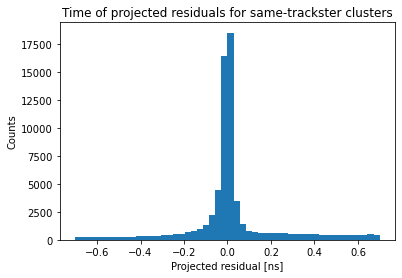

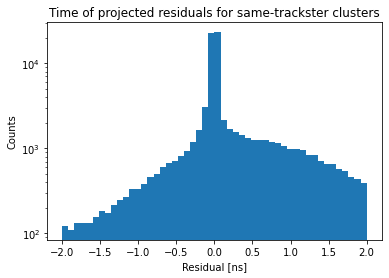

Info in <TCanvas::Print>: png file Plots/h2_proj_newmethod_trackster.png has been created
Info in <TCanvas::Print>: pdf file Plots/h2_proj_newmethod_trackster.pdf has been created
Info in <TCanvas::Print>: png file Plots/h2_proj_newmethod_log_trackster.png has been created
Info in <TCanvas::Print>: pdf file Plots/h2_proj_newmethod_log_trackster.pdf has been created


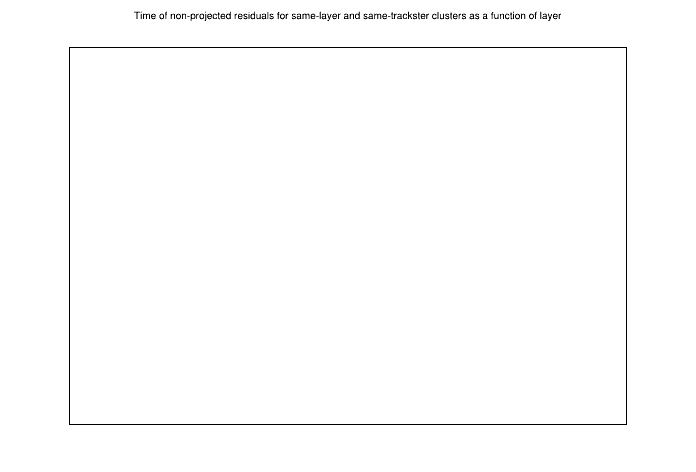

In [12]:
#New calculation, using trackster time



print(f_clusters.keys())

print(f_trackstersMerged.keys())

trackster_time=f_trackstersMerged["time"].array()
trackster_timeError=f_trackstersMerged["timeError"].array()
tr_barycenter_z=f_trackstersMerged["barycenter_z"].array()

vertices_time=f_trackstersMerged["vertices_time"].array()
vertices_indexes=f_trackstersMerged["vertices_indexes"].array()

print(vertices_time)

print(vertices_indexes[0])

#print([len(x) for x in vertices_time])




print(f_clusters["cluster_time"].array())
print(f_clusters["cluster_layer_id"].array())


cluster_time=f_clusters["cluster_time"].array()
cluster_energy=f_clusters["correctedEnergy"].array()
cluster_layer=f_clusters["cluster_layer_id"].array()
cluster_x=f_clusters['position_x'].array()
cluster_y=f_clusters['position_y'].array()
cluster_z=f_clusters['position_z'].array()
cluster_time_error=f_clusters["cluster_timeErr"].array()



print("cl_energy", type(cluster_energy))
n_elem= [len(x) for x in cluster_time]

#print("n_elem: ", n_elem)

time_residuals_proj=[]

times_list=[]
nlayers=47
for i in range(nlayers):
    times_list.append([])

mask=(cluster_time!=-99)
#print(mask)

#ntimes=[len(x) for x in cluster_time]
#print("number of clusters:", ntimes)

cluster_time_clean=cluster_time[mask]
cluster_time_error_clean=cluster_time_error[mask]
cluster_energy_clean=cluster_energy[mask]
cluster_layer_clean=cluster_layer[mask]
cluster_x_clean=cluster_x[mask]
cluster_y_clean=cluster_y[mask]
cluster_z_clean=cluster_z[mask]
#print(len(cluster_time_clean))
#ntimes=[len(x) for x in cluster_time_clean]
#print(ntimes)
nlayers=47

file = ROOT.TFile.Open("Plots/plots_proj.root", "RECREATE")


res_layer=ROOT.TH2F("t_res_proj","Time of projected residuals for same-trackster clusters as a function of layer;Residual [ns];Layer",50,-1.,1.,nlayers,0.5,nlayers+0.5)
res_layer_sigma=ROOT.TH2F("t_res_sigma","Time residuals/error as a function of layer;Residual ;Layer",50,-3.,3.,nlayers,0.5,nlayers+0.5)

#mask_neg=(cluster_energy>100)
#print(cluster_energy[mask_neg])    

for i in tqdm(range(len(vertices_indexes))):
    for k in range(len(vertices_indexes[i])):
        if trackster_timeError[i][k]==-99:
            continue
        mask_trackster=np.full((len(cluster_time[i])), False)
        for l in range(len(vertices_indexes[i][k])):
            mask_trackster[vertices_indexes[i][k][l]]=True
            
            
            
        mask_trackster=ak.Array(mask_trackster)
        mask_trackster_1=mask[i] & mask_trackster
        
        cluster_time_trackster=cluster_time[i][mask_trackster_1]
        cluster_time_error_trackster=cluster_time_error[i][mask_trackster_1]
        cluster_energy_trackster=cluster_energy[i][mask_trackster_1]
        cluster_layer_trackster=cluster_layer[i][mask_trackster_1]
        cluster_x_trackster=cluster_x[i][mask_trackster_1]
        cluster_y_trackster=cluster_y[i][mask_trackster_1]
        cluster_z_trackster=cluster_z[i][mask_trackster_1]
        
        
        
        
        for side in [-1.,1.]:
            #mask_side_all=(side*cluster_z[i]>0)
            barycenter_z=tr_barycenter_z[i][k]#compute_barycenter_z(cluster_energy[i][mask_side_all],cluster_z[i][mask_side_all])
            
            mask_side=(cluster_z_trackster>-9999.)#side*cluster_z_trackster>0)
            cluster_layer_side=cluster_layer_trackster[mask_side]
            cluster_time_side=cluster_time_trackster[mask_side]
            cluster_time_error_side=cluster_time_error_trackster[mask_side]
            cluster_x_side=cluster_x_trackster[mask_side]
            cluster_y_side=cluster_y_trackster[mask_side]
            cluster_z_side=cluster_z_trackster[mask_side]
            cluster_energy_side=cluster_energy_trackster[mask_side]
        
            for layer in range(nlayers):
                mask_layer=(cluster_layer_side==layer)
                cluster_time_layer=cluster_time_side[mask_layer]
                cluster_time_error_layer=cluster_time_error_side[mask_layer]
                cluster_energy_layer=cluster_energy_side[mask_layer]

                cluster_x_layer=cluster_x_side[mask_layer]
                cluster_y_layer=cluster_y_side[mask_layer]
                cluster_z_layer=cluster_z_side[mask_layer]

                if(len(cluster_energy_layer))>0:
                    max_idx=ak.argmax(cluster_energy_layer)
                    for j in range(len(cluster_energy_layer)):
                        if True:
                            #proj_pos_max=prop_to_bar([cluster_x_layer[max_idx],cluster_y_layer[max_idx],cluster_z_layer[max_idx]], barycenter_z)
                            #proj_time_max=cluster_time_layer[max_idx]+side*theta(barycenter_z-cluster_z_layer[max_idx])*distance(proj_pos_max[0],proj_pos_max[1],proj_pos_max[2],cluster_x_layer[max_idx],cluster_y_layer[max_idx],cluster_z_layer[max_idx])/C
                            #print(side*theta(barycenter_z-cluster_z_layer[max_idx])*distance(proj_pos_max[0],proj_pos_max[1],proj_pos_max[2],cluster_x_layer[max_idx],cluster_y_layer[max_idx],cluster_z_layer[max_idx])/C)

                            proj_pos_j=prop_to_bar([cluster_x_layer[j],cluster_y_layer[j],cluster_z_layer[j]], barycenter_z)
                            proj_time_j=cluster_time_layer[j]+theta(barycenter_z)*theta(barycenter_z-cluster_z_layer[j])*distance(proj_pos_j[0],proj_pos_j[1],proj_pos_j[2],cluster_x_layer[j],cluster_y_layer[j],cluster_z_layer[j])/C
                            #print(side*theta(barycenter_z-cluster_z_layer[j])*distance(proj_pos_j[0],proj_pos_j[1],proj_pos_j[2],cluster_x_layer[j],cluster_y_layer[j],cluster_z_layer[j])/C)

                            time_residuals_proj.append(trackster_time[i][k]-proj_time_j)
                            res_layer.Fill(trackster_time[i][k]-proj_time_j,layer)
                            #res_layer_sigma.Fill((cluster_time_layer[max_idx]-cluster_time_layer[j])/(cluster_time_error_layer[max_idx]**2+cluster_time_error_layer[j]**2)**0.5,layer)



ROOT.gStyle.SetOptStat(11);

c1=ROOT.TCanvas()
c1.cd()
res_layer.Draw("COLZ")
c1.SaveAs("Plots/h2_proj_newmethod_trackster.png")
c1.SaveAs("Plots/h2_proj_newmethod_trackster.pdf")

c1.Draw()

c1.SetLogz()
c1.Draw()
c1.SaveAs("Plots/h2_proj_newmethod_log_trackster.png")

c1.SaveAs("Plots/h2_proj_newmethod_log_trackster.pdf")


c1.Write()
res_layer.Write()
file.Close()

'''
c2=ROOT.TCanvas()
c2.cd()
res_layer_sigma.Draw("COLZ")
c2.SaveAs("h2_sigma.png")
c2.Draw()

c2.SetLogz()
c2.Draw()
c2.SaveAs("h2_sigma_log.png")
'''


plt.title("Time of projected residuals for same-trackster clusters")
plt.xlabel("Projected residual [ns]")
plt.ylabel("Counts")
plt.hist(time_residuals_proj,bins=50, range=[-0.7,0.7])#,color="C1")

plt.savefig('Plots/h1_proj_newmethod_trackster.pdf')  
plt.show() 

plt.title("Time of projected residuals for same-trackster clusters")
plt.xlabel("Residual [ns]")
plt.ylabel("Counts")


plt.hist(time_residuals_proj,bins=50,log=True,range=[-2,2])#, range=[0,0.1])
plt.savefig('Plots/h1_proj_newmethodj_log_trackster.pdf')  

plt.show() 

# Correct calculation beta=1

In [25]:
#New calculation, using trackster time



print(f_clusters.keys())

print(f_trackstersMerged.keys())

trackster_time=f_trackstersMerged["time"].array()
trackster_timeError=f_trackstersMerged["timeError"].array()
tr_barycenter_z=f_trackstersMerged["barycenter_z"].array()
tr_barycenter_x=f_trackstersMerged["barycenter_x"].array()
tr_barycenter_y=f_trackstersMerged["barycenter_y"].array()

vertices_time=f_trackstersMerged["vertices_time"].array()
vertices_indexes=f_trackstersMerged["vertices_indexes"].array()

print(vertices_time)

print(vertices_indexes[0])

#print([len(x) for x in vertices_time])




print(f_clusters["cluster_time"].array())
print(f_clusters["cluster_layer_id"].array())


cluster_time=f_clusters["cluster_time"].array()
cluster_energy=f_clusters["correctedEnergy"].array()
cluster_layer=f_clusters["cluster_layer_id"].array()
cluster_x=f_clusters['position_x'].array()
cluster_y=f_clusters['position_y'].array()
cluster_z=f_clusters['position_z'].array()
cluster_time_error=f_clusters["cluster_timeErr"].array()
cluster_type=f_clusters['cluster_type'].array()

prefix=str(1.0)

print("cl_energy", type(cluster_energy))
n_elem= [len(x) for x in cluster_time]

#print("n_elem: ", n_elem)

time_residuals_proj=[]

times_list=[]
nlayers=47
for i in range(nlayers):
    times_list.append([])

mask=(cluster_time!=-99)
#print(mask)

#ntimes=[len(x) for x in cluster_time]
#print("number of clusters:", ntimes)

cluster_time_clean=cluster_time[mask]
cluster_time_error_clean=cluster_time_error[mask]
cluster_energy_clean=cluster_energy[mask]
cluster_layer_clean=cluster_layer[mask]
cluster_x_clean=cluster_x[mask]
cluster_y_clean=cluster_y[mask]
cluster_z_clean=cluster_z[mask]
cluster_type_clean=cluster_type[mask]

n_scint=0
n_scint_time=0
for i in tqdm(range(len(cluster_type))):
    for j in range(len(cluster_type[i])):
        if cluster_type[i][j]==8:
            if cluster_time[i][j]!=-99:
                n_scint_time+=1
            n_scint+=1
print("n tot:", n_scint,"\nn with time:",n_scint_time)
print("\nfraction:",n_scint_time/n_scint)
    
time_scint=[x for x in cluster_type_clean]
#print(len(cluster_time_clean))
#ntimes=[len(x) for x in cluster_time_clean]
#print(ntimes)
nlayers=47

file = ROOT.TFile.Open("Plots/plots_proj"+prefix+".root", "RECREATE")


res_layer=ROOT.TH2F("t_res_proj","Time of projected residuals for same-trackster clusters as a function of layer;Residual [ns];Layer",50,-1.,1.,nlayers,0.5,nlayers+0.5)
res_zdist=ROOT.TH2F("t_res_zdist","Projected residuals vs z-distance from barycenter;Residual [ns]; z distance [cm]",50,-1.,1.,50,-60,60)
res_dist=ROOT.TH2F("t_res_dist","Projected residuals vs distance from barycenter;Residual [ns]; Distance [cm]",50,-1.,1.,50,0.0,100)
res_scintillator=ROOT.TH2F("t_res_proj_scint","Time of projected residuals for same-trackster clusters as a function of layer, type=8;Residual [ns];Layer",50,-1.,1.,nlayers,0.5,nlayers+0.5)
res_layer_sigma=ROOT.TH2F("t_res_sigma","Time residuals/error as a function of layer;Residual ;Layer",50,-3.,3.,nlayers,0.5,nlayers+0.5)

#mask_neg=(cluster_energy>100)
#print(cluster_energy[mask_neg])    

for i in tqdm(range(len(vertices_indexes))):
    for k in range(len(vertices_indexes[i])):
        if trackster_timeError[i][k]==-99:
            continue
        mask_trackster=np.full((len(cluster_time[i])), False)
        for l in range(len(vertices_indexes[i][k])):
            mask_trackster[vertices_indexes[i][k][l]]=True
            
            
            
        mask_trackster=ak.Array(mask_trackster)
        mask_trackster_1=mask[i] & mask_trackster
        
        cluster_time_trackster=cluster_time[i][mask_trackster_1]
        cluster_time_error_trackster=cluster_time_error[i][mask_trackster_1]
        cluster_energy_trackster=cluster_energy[i][mask_trackster_1]
        cluster_layer_trackster=cluster_layer[i][mask_trackster_1]
        cluster_x_trackster=cluster_x[i][mask_trackster_1]
        cluster_y_trackster=cluster_y[i][mask_trackster_1]
        cluster_z_trackster=cluster_z[i][mask_trackster_1]
        cluster_type_trackster=cluster_type[i][mask_trackster_1]
        
        barycenter_z=tr_barycenter_z[i][k] #compute_barycenter_z(cluster_energy[i][mask_side_all],cluster_z[i][mask_side_all])
        barycenter_x=tr_barycenter_x[i][k]
        barycenter_y=tr_barycenter_y[i][k]
        
        for layer in range(nlayers):
            
            mask_layer=(cluster_layer_trackster==layer)
            cluster_time_layer=cluster_time_trackster[mask_layer]
            cluster_time_error_layer=cluster_time_error_trackster[mask_layer]
            cluster_energy_layer=cluster_energy_trackster[mask_layer]
            cluster_type_layer=cluster_type_trackster[mask_layer]
            cluster_x_layer=cluster_x_trackster[mask_layer]
            cluster_y_layer=cluster_y_trackster[mask_layer]
            cluster_z_layer=cluster_z_trackster[mask_layer]

            if(len(cluster_energy_layer))>0:
                #max_idx=ak.argmax(cluster_energy_layer)
                for j in range(len(cluster_energy_layer)):
                    #proj_pos_max=prop_to_bar([cluster_x_layer[max_idx],cluster_y_layer[max_idx],cluster_z_layer[max_idx]], barycenter_z)
                    #proj_time_max=cluster_time_layer[max_idx]+side*theta(barycenter_z-cluster_z_layer[max_idx])*distance(proj_pos_max[0],proj_pos_max[1],proj_pos_max[2],cluster_x_layer[max_idx],cluster_y_layer[max_idx],cluster_z_layer[max_idx])/C
                    #print(side*theta(barycenter_z-cluster_z_layer[max_idx])*distance(proj_pos_max[0],proj_pos_max[1],proj_pos_max[2],cluster_x_layer[max_idx],cluster_y_layer[max_idx],cluster_z_layer[max_idx])/C)

                    proj_pos_j=prop_to_bar([cluster_x_layer[j],cluster_y_layer[j],cluster_z_layer[j]], barycenter_z)
                    proj_time_j=cluster_time_layer[j]+theta(barycenter_z)*theta(barycenter_z-cluster_z_layer[j])*distance(proj_pos_j[0],proj_pos_j[1],proj_pos_j[2],cluster_x_layer[j],cluster_y_layer[j],cluster_z_layer[j])/(C)
                    #print(side*theta(barycenter_z-cluster_z_layer[j])*distance(proj_pos_j[0],proj_pos_j[1],proj_pos_j[2],cluster_x_layer[j],cluster_y_layer[j],cluster_z_layer[j])/C)

                    time_residuals_proj.append(trackster_time[i][k]-proj_time_j)
                    res_layer.Fill(trackster_time[i][k]-proj_time_j,layer)
                    if(barycenter_z>0):
                        res_zdist.Fill(trackster_time[i][k]-proj_time_j,(cluster_z_layer[j]-barycenter_z)*theta(barycenter_z))
                        res_dist.Fill(trackster_time[i][k]-proj_time_j,distance(barycenter_x,barycenter_y,barycenter_z,cluster_x_layer[j],cluster_y_layer[j],cluster_z_layer[j]))
                    if(cluster_type_layer[j]==8):
                        res_scintillator.Fill(trackster_time[i][k]-proj_time_j,layer)
                    
                    #res_layer_sigma.Fill((cluster_time_layer[max_idx]-cluster_time_layer[j])/(cluster_time_error_layer[max_idx]**2+cluster_time_error_layer[j]**2)**0.5,layer)



ROOT.gStyle.SetOptStat(11);

c1=ROOT.TCanvas()
c1.cd()
res_layer.Draw("COLZ")
c1.SaveAs("Plots/h2_proj_newmethod_trackster_"+prefix+".png")
c1.SaveAs("Plots/h2_proj_newmethod_trackster_"+prefix+".pdf")

c1.Draw()

c1.SetLogz()
c1.Draw()
c1.SaveAs("Plots/h2_proj_newmethod_log_trackster_"+prefix+".png")

c1.SaveAs("Plots/h2_proj_newmethod_log_trackster_"+prefix+".pdf")


c1.Write()
res_layer.Write()
res_zdist.Write()
res_dist.Write()
file.Close()

'''
c2=ROOT.TCanvas()
c2.cd()
res_layer_sigma.Draw("COLZ")
c2.SaveAs("h2_sigma.png")
c2.Draw()

c2.SetLogz()
c2.Draw()
c2.SaveAs("h2_sigma_log.png")
'''


plt.title("Time of projected residuals for same-trackster clusters")
plt.xlabel("Projected residual [ns]")
plt.ylabel("Counts")
plt.hist(time_residuals_proj,bins=50, range=[-0.7,0.7])#,color="C1")

plt.savefig("Plots/h1_proj_newmethod_trackster_"+prefix+".pdf")  
plt.show() 

plt.title("Time of projected residuals for same-trackster clusters")
plt.xlabel("Residual [ns]")
plt.ylabel("Counts")


plt.hist(time_residuals_proj,bins=50,log=True,range=[-2,2])#, range=[0,0.1])
plt.savefig("Plots/h1_proj_newmethodj_log_trackster_"+prefix+".pdf")  

plt.show() 

['seedID', 'energy', 'correctedEnergy', 'correctedEnergyUncertainty', 'position_x', 'position_y', 'position_z', 'position_eta', 'position_phi', 'cluster_layer_id', 'cluster_type', 'cluster_time', 'cluster_timeErr', 'cluster_number_of_hits']
['event', 'time', 'timeError', 'regressed_energy', 'raw_energy', 'raw_em_energy', 'raw_pt', 'raw_em_pt', 'NTrackstersMerged', 'barycenter_x', 'barycenter_y', 'barycenter_z', 'barycenter_eta', 'barycenter_phi', 'EV1', 'EV2', 'EV3', 'eVector0_x', 'eVector0_y', 'eVector0_z', 'sigmaPCA1', 'sigmaPCA2', 'sigmaPCA3', 'id_probabilities', 'vertices_indexes', 'vertices_x', 'vertices_y', 'vertices_z', 'vertices_time', 'vertices_timeErr', 'vertices_energy', 'vertices_correctedEnergy', 'vertices_correctedEnergyUncertainty', 'vertices_multiplicity']
[[[11, 11, 11, 11, 11.1, 11.2, 11.1, 11.2, -99, ... -99, -99], [-99, -99, -99, -99]]]
[[336, 340, 344, 348, 362, 367, 371, 384, ... 546, 556, 570, 583, 607, 619, 622]]
[[-99, -99, -99, -99, -99, -99, -99, -99, ... -99

100%|██████████| 1000/1000 [01:11<00:00, 14.02it/s]

n tot: 0 
n with time: 0


ZeroDivisionError: division by zero

# beta 0.96

In [49]:
#New calculation, using trackster time



print(f_clusters.keys())

print(f_trackstersMerged.keys())

trackster_time=f_trackstersMerged["time"].array()
trackster_timeError=f_trackstersMerged["timeError"].array()
tr_barycenter_z=f_trackstersMerged["barycenter_z"].array()
tr_barycenter_x=f_trackstersMerged["barycenter_x"].array()
tr_barycenter_y=f_trackstersMerged["barycenter_y"].array()

vertices_time=f_trackstersMerged["vertices_time"].array()
vertices_indexes=f_trackstersMerged["vertices_indexes"].array()

print(vertices_time)

print(vertices_indexes[0])

#print([len(x) for x in vertices_time])




print(f_clusters["cluster_time"].array())
print(f_clusters["cluster_layer_id"].array())


cluster_time=f_clusters["cluster_time"].array()
cluster_energy=f_clusters["correctedEnergy"].array()
cluster_layer=f_clusters["cluster_layer_id"].array()
cluster_x=f_clusters['position_x'].array()
cluster_y=f_clusters['position_y'].array()
cluster_z=f_clusters['position_z'].array()
cluster_time_error=f_clusters["cluster_timeErr"].array()

prefix=str(0.96)

print("cl_energy", type(cluster_energy))
n_elem= [len(x) for x in cluster_time]

#print("n_elem: ", n_elem)

time_residuals_proj=[]

times_list=[]
nlayers=47
for i in range(nlayers):
    times_list.append([])

mask=(cluster_time!=-99)
#print(mask)

#ntimes=[len(x) for x in cluster_time]
#print("number of clusters:", ntimes)

cluster_time_clean=cluster_time[mask]
cluster_time_error_clean=cluster_time_error[mask]
cluster_energy_clean=cluster_energy[mask]
cluster_layer_clean=cluster_layer[mask]
cluster_x_clean=cluster_x[mask]
cluster_y_clean=cluster_y[mask]
cluster_z_clean=cluster_z[mask]
#print(len(cluster_time_clean))
#ntimes=[len(x) for x in cluster_time_clean]
#print(ntimes)
nlayers=47

file = ROOT.TFile.Open("Plots/plots_proj"+prefix+".root", "RECREATE")


res_layer=ROOT.TH2F("t_res_proj","Time of projected residuals for same-trackster clusters as a function of layer;Residual [ns];Layer",50,-1.,1.,nlayers,0.5,nlayers+0.5)
res_zdist=ROOT.TH2F("t_res_zdist","Projected residuals vs z-distance from barycenter;Residual [ns]; z distance [cm]",50,-1.,1.,50,-60,60)
res_dist=ROOT.TH2F("t_res_dist","Projected residuals vs distance from barycenter;Residual [ns]; Distance [cm]",50,-1.,1.,50,0.0,100)

res_layer_sigma=ROOT.TH2F("t_res_sigma","Time residuals/error as a function of layer;Residual ;Layer",50,-3.,3.,nlayers,0.5,nlayers+0.5)

#mask_neg=(cluster_energy>100)
#print(cluster_energy[mask_neg])    

for i in tqdm(range(len(vertices_indexes))):
    for k in range(len(vertices_indexes[i])):
        if trackster_timeError[i][k]==-99:
            continue
        mask_trackster=np.full((len(cluster_time[i])), False)
        for l in range(len(vertices_indexes[i][k])):
            mask_trackster[vertices_indexes[i][k][l]]=True
            
            
            
        mask_trackster=ak.Array(mask_trackster)
        mask_trackster_1=mask[i] & mask_trackster
        
        cluster_time_trackster=cluster_time[i][mask_trackster_1]
        cluster_time_error_trackster=cluster_time_error[i][mask_trackster_1]
        cluster_energy_trackster=cluster_energy[i][mask_trackster_1]
        cluster_layer_trackster=cluster_layer[i][mask_trackster_1]
        cluster_x_trackster=cluster_x[i][mask_trackster_1]
        cluster_y_trackster=cluster_y[i][mask_trackster_1]
        cluster_z_trackster=cluster_z[i][mask_trackster_1]
        
        barycenter_z=tr_barycenter_z[i][k] #compute_barycenter_z(cluster_energy[i][mask_side_all],cluster_z[i][mask_side_all])
        barycenter_x=tr_barycenter_x[i][k]
        barycenter_y=tr_barycenter_y[i][k]
        
        for layer in range(nlayers):
            
            mask_layer=(cluster_layer_trackster==layer)
            cluster_time_layer=cluster_time_trackster[mask_layer]
            cluster_time_error_layer=cluster_time_error_trackster[mask_layer]
            cluster_energy_layer=cluster_energy_trackster[mask_layer]

            cluster_x_layer=cluster_x_trackster[mask_layer]
            cluster_y_layer=cluster_y_trackster[mask_layer]
            cluster_z_layer=cluster_z_trackster[mask_layer]

            if(len(cluster_energy_layer))>0:
                #max_idx=ak.argmax(cluster_energy_layer)
                for j in range(len(cluster_energy_layer)):
                    #proj_pos_max=prop_to_bar([cluster_x_layer[max_idx],cluster_y_layer[max_idx],cluster_z_layer[max_idx]], barycenter_z)
                    #proj_time_max=cluster_time_layer[max_idx]+side*theta(barycenter_z-cluster_z_layer[max_idx])*distance(proj_pos_max[0],proj_pos_max[1],proj_pos_max[2],cluster_x_layer[max_idx],cluster_y_layer[max_idx],cluster_z_layer[max_idx])/C
                    #print(side*theta(barycenter_z-cluster_z_layer[max_idx])*distance(proj_pos_max[0],proj_pos_max[1],proj_pos_max[2],cluster_x_layer[max_idx],cluster_y_layer[max_idx],cluster_z_layer[max_idx])/C)

                    proj_pos_j=prop_to_bar([cluster_x_layer[j],cluster_y_layer[j],cluster_z_layer[j]], barycenter_z)
                    proj_time_j=cluster_time_layer[j]+theta(barycenter_z)*theta(barycenter_z-cluster_z_layer[j])*distance(proj_pos_j[0],proj_pos_j[1],proj_pos_j[2],cluster_x_layer[j],cluster_y_layer[j],cluster_z_layer[j])/(C*0.96)
                    #print(side*theta(barycenter_z-cluster_z_layer[j])*distance(proj_pos_j[0],proj_pos_j[1],proj_pos_j[2],cluster_x_layer[j],cluster_y_layer[j],cluster_z_layer[j])/C)

                    time_residuals_proj.append(trackster_time[i][k]-proj_time_j)
                    res_layer.Fill(trackster_time[i][k]-proj_time_j,layer)
                    if(barycenter_z>0):
                        res_zdist.Fill(trackster_time[i][k]-proj_time_j,(cluster_z_layer[j]-barycenter_z)*theta(barycenter_z))
                        res_dist.Fill(trackster_time[i][k]-proj_time_j,distance(barycenter_x,barycenter_y,barycenter_z,cluster_x_layer[j],cluster_y_layer[j],cluster_z_layer[j]))
                    
                    #res_layer_sigma.Fill((cluster_time_layer[max_idx]-cluster_time_layer[j])/(cluster_time_error_layer[max_idx]**2+cluster_time_error_layer[j]**2)**0.5,layer)



ROOT.gStyle.SetOptStat(11);

c1=ROOT.TCanvas()
c1.cd()
res_layer.Draw("COLZ")
c1.SaveAs("Plots/h2_proj_newmethod_trackster_"+prefix+".png")
c1.SaveAs("Plots/h2_proj_newmethod_trackster_"+prefix+".pdf")

c1.Draw()

c1.SetLogz()
c1.Draw()
c1.SaveAs("Plots/h2_proj_newmethod_log_trackster_"+prefix+".png")

c1.SaveAs("Plots/h2_proj_newmethod_log_trackster_"+prefix+".pdf")


c1.Write()
res_layer.Write()
res_zdist.Write()
res_dist.Write()
file.Close()

'''
c2=ROOT.TCanvas()
c2.cd()
res_layer_sigma.Draw("COLZ")
c2.SaveAs("h2_sigma.png")
c2.Draw()

c2.SetLogz()
c2.Draw()
c2.SaveAs("h2_sigma_log.png")
'''


plt.title("Time of projected residuals for same-trackster clusters")
plt.xlabel("Projected residual [ns]")
plt.ylabel("Counts")
plt.hist(time_residuals_proj,bins=50, range=[-0.7,0.7])#,color="C1")

plt.savefig("Plots/h1_proj_newmethod_trackster_"+prefix+".pdf")  
plt.show() 

plt.title("Time of projected residuals for same-trackster clusters")
plt.xlabel("Residual [ns]")
plt.ylabel("Counts")


plt.hist(time_residuals_proj,bins=50,log=True,range=[-2,2])#, range=[0,0.1])
plt.savefig("Plots/h1_proj_newmethodj_log_trackster_"+prefix+".pdf")  

plt.show() 

['seedID', 'energy', 'correctedEnergy', 'correctedEnergyUncertainty', 'position_x', 'position_y', 'position_z', 'position_eta', 'position_phi', 'cluster_layer_id', 'cluster_type', 'cluster_time', 'cluster_timeErr', 'cluster_number_of_hits']
['event', 'time', 'timeError', 'regressed_energy', 'raw_energy', 'raw_em_energy', 'raw_pt', 'raw_em_pt', 'NTrackstersMerged', 'barycenter_x', 'barycenter_y', 'barycenter_z', 'barycenter_eta', 'barycenter_phi', 'EV1', 'EV2', 'EV3', 'eVector0_x', 'eVector0_y', 'eVector0_z', 'sigmaPCA1', 'sigmaPCA2', 'sigmaPCA3', 'id_probabilities', 'vertices_indexes', 'vertices_x', 'vertices_y', 'vertices_z', 'vertices_time', 'vertices_timeErr', 'vertices_energy', 'vertices_correctedEnergy', 'vertices_correctedEnergyUncertainty', 'vertices_multiplicity']


KeyboardInterrupt: 

# New calculation, with moliere radius

In [19]:
import math
def norm(vec):
    return math.sqrt(vec[0]**2+vec[1]**2 +vec[2]**2)

def point_line_dist(lp1,lp2,p):
    #print(np.linalg.vector_norm([1,1,1]))
    lp1_np=np.array(lp1)
    lp2_np=np.array(lp2)
    p_np=np.array(p)
    #print("val:",(np.cross((p_np-lp1_np),(p_np-lp2_np))))
    return norm((np.cross((p_np-lp1_np),(p_np-lp2_np))))/norm(lp1_np-lp2_np)
    #print("val",(np.cross((lp2_np-lp1_np),(lp1_np-p))))
    #print("val:",norm(lp2_np-lp1_np))
    #return norm((np.cross((lp2_np-lp1_np),(lp1_np-p))))/norm(lp2_np-lp1_np)



['seedID', 'energy', 'correctedEnergy', 'correctedEnergyUncertainty', 'position_x', 'position_y', 'position_z', 'position_eta', 'position_phi', 'cluster_layer_id', 'cluster_type', 'cluster_time', 'cluster_timeErr', 'cluster_number_of_hits']
['event', 'time', 'timeError', 'regressed_energy', 'raw_energy', 'raw_em_energy', 'raw_pt', 'raw_em_pt', 'NTrackstersMerged', 'barycenter_x', 'barycenter_y', 'barycenter_z', 'barycenter_eta', 'barycenter_phi', 'EV1', 'EV2', 'EV3', 'eVector0_x', 'eVector0_y', 'eVector0_z', 'sigmaPCA1', 'sigmaPCA2', 'sigmaPCA3', 'id_probabilities', 'vertices_indexes', 'vertices_x', 'vertices_y', 'vertices_z', 'vertices_time', 'vertices_timeErr', 'vertices_energy', 'vertices_correctedEnergy', 'vertices_correctedEnergyUncertainty', 'vertices_multiplicity']
[[[11, 11, 11, 11, 11.1, 11.2, 11.1, 11.2, -99, ... -99, -99], [-99, -99, -99, -99]]]
[[336, 340, 344, 348, 362, 367, 371, 384, ... 546, 556, 570, 583, 607, 619, 622]]
[[-99, -99, -99, -99, -99, -99, -99, -99, ... -99

100%|██████████| 1000/1000 [20:37<00:00,  1.24s/it]


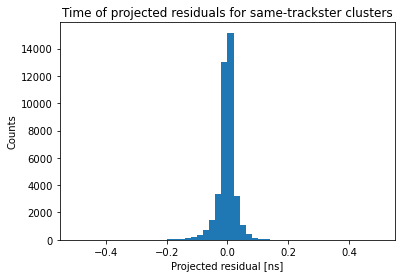

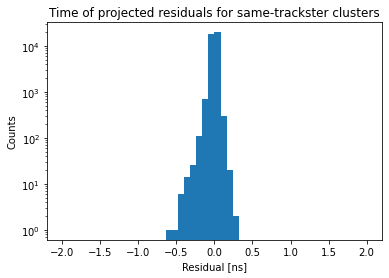

Info in <TCanvas::Print>: png file Plots/h2_proj_newmethod_trackster_moliere.png has been created
Info in <TCanvas::Print>: pdf file Plots/h2_proj_newmethod_trackster_moliere.pdf has been created
Info in <TCanvas::Print>: png file Plots/h2_proj_newmethod_log_trackster_moliere.png has been created
Info in <TCanvas::Print>: pdf file Plots/h2_proj_newmethod_log_trackster_moliere.pdf has been created


In [20]:
#New calculation, with moliere radius



print(f_clusters.keys())

print(f_trackstersMerged.keys())

trackster_time=f_trackstersMerged["time"].array()
trackster_timeError=f_trackstersMerged["timeError"].array()
tr_barycenter_z=f_trackstersMerged["barycenter_z"].array()
tr_barycenter_x=f_trackstersMerged["barycenter_x"].array()
tr_barycenter_y=f_trackstersMerged["barycenter_y"].array()

vertices_time=f_trackstersMerged["vertices_time"].array()
vertices_indexes=f_trackstersMerged["vertices_indexes"].array()

print(vertices_time)

print(vertices_indexes[0])

#print([len(x) for x in vertices_time])




print(f_clusters["cluster_time"].array())
print(f_clusters["cluster_layer_id"].array())


cluster_time=f_clusters["cluster_time"].array()
cluster_energy=f_clusters["correctedEnergy"].array()
cluster_layer=f_clusters["cluster_layer_id"].array()
cluster_x=f_clusters['position_x'].array()
cluster_y=f_clusters['position_y'].array()
cluster_z=f_clusters['position_z'].array()
cluster_time_error=f_clusters["cluster_timeErr"].array()

prefix="moliere"

print("cl_energy", type(cluster_energy))
n_elem= [len(x) for x in cluster_time]

#print("n_elem: ", n_elem)

time_residuals_proj=[]

times_list=[]
nlayers=47
for i in range(nlayers):
    times_list.append([])

mask=(cluster_time!=-99)
#print(mask)

#ntimes=[len(x) for x in cluster_time]
#print("number of clusters:", ntimes)

cluster_time_clean=cluster_time[mask]
cluster_time_error_clean=cluster_time_error[mask]
cluster_energy_clean=cluster_energy[mask]
cluster_layer_clean=cluster_layer[mask]
cluster_x_clean=cluster_x[mask]
cluster_y_clean=cluster_y[mask]
cluster_z_clean=cluster_z[mask]
#print(len(cluster_time_clean))
#ntimes=[len(x) for x in cluster_time_clean]
#print(ntimes)
nlayers=47

file = ROOT.TFile.Open("Plots/plots_proj"+prefix+".root", "RECREATE")


res_layer=ROOT.TH2F("t_res_proj","Time of projected residuals for same-trackster clusters as a function of layer;Residual [ns];Layer",50,-1.,1.,nlayers,0.5,nlayers+0.5)
res_zdist=ROOT.TH2F("t_res_zdist","Projected residuals vs z-distance from barycenter;Residual [ns]; z distance [cm]",50,-1.,1.,50,-60,60)
res_dist=ROOT.TH2F("t_res_dist","Projected residuals vs distance from barycenter;Residual [ns]; Distance [cm]",50,-1.,1.,50,0.0,100)

res_layer_sigma=ROOT.TH2F("t_res_sigma","Time residuals/error as a function of layer;Residual ;Layer",50,-3.,3.,nlayers,0.5,nlayers+0.5)

#mask_neg=(cluster_energy>100)
#print(cluster_energy[mask_neg])    

for i in tqdm(range(len(vertices_indexes))):
    for k in range(len(vertices_indexes[i])):
        if trackster_timeError[i][k]==-99:
            continue
        mask_trackster=np.full((len(cluster_time[i])), False)
        for l in range(len(vertices_indexes[i][k])):
            mask_trackster[vertices_indexes[i][k][l]]=True
            
            
            
        mask_trackster=ak.Array(mask_trackster)
        mask_trackster_1=mask[i] & mask_trackster
        
        cluster_time_trackster=cluster_time[i][mask_trackster_1]
        cluster_time_error_trackster=cluster_time_error[i][mask_trackster_1]
        cluster_energy_trackster=cluster_energy[i][mask_trackster_1]
        cluster_layer_trackster=cluster_layer[i][mask_trackster_1]
        cluster_x_trackster=cluster_x[i][mask_trackster_1]
        cluster_y_trackster=cluster_y[i][mask_trackster_1]
        cluster_z_trackster=cluster_z[i][mask_trackster_1]
        
        barycenter_z=tr_barycenter_z[i][k] #compute_barycenter_z(cluster_energy[i][mask_side_all],cluster_z[i][mask_side_all])
        barycenter_x=tr_barycenter_x[i][k]
        barycenter_y=tr_barycenter_y[i][k]
        
        for layer in range(nlayers):
            
            mask_layer=(cluster_layer_trackster==layer)
            cluster_time_layer=cluster_time_trackster[mask_layer]
            cluster_time_error_layer=cluster_time_error_trackster[mask_layer]
            cluster_energy_layer=cluster_energy_trackster[mask_layer]

            cluster_x_layer=cluster_x_trackster[mask_layer]
            cluster_y_layer=cluster_y_trackster[mask_layer]
            cluster_z_layer=cluster_z_trackster[mask_layer]

            if(len(cluster_energy_layer))>0:
                #max_idx=ak.argmax(cluster_energy_layer)
                for j in range(len(cluster_energy_layer)):
                    #proj_pos_max=prop_to_bar([cluster_x_layer[max_idx],cluster_y_layer[max_idx],cluster_z_layer[max_idx]], barycenter_z)
                    #proj_time_max=cluster_time_layer[max_idx]+side*theta(barycenter_z-cluster_z_layer[max_idx])*distance(proj_pos_max[0],proj_pos_max[1],proj_pos_max[2],cluster_x_layer[max_idx],cluster_y_layer[max_idx],cluster_z_layer[max_idx])/C
                    #print(side*theta(barycenter_z-cluster_z_layer[max_idx])*distance(proj_pos_max[0],proj_pos_max[1],proj_pos_max[2],cluster_x_layer[max_idx],cluster_y_layer[max_idx],cluster_z_layer[max_idx])/C)

                    proj_pos_j=prop_to_bar([cluster_x_layer[j],cluster_y_layer[j],cluster_z_layer[j]], barycenter_z)
                    proj_time_j=cluster_time_layer[j]+theta(barycenter_z)*theta(barycenter_z-cluster_z_layer[j])*distance(proj_pos_j[0],proj_pos_j[1],proj_pos_j[2],cluster_x_layer[j],cluster_y_layer[j],cluster_z_layer[j])/(C)
                    #print(side*theta(barycenter_z-cluster_z_layer[j])*distance(proj_pos_j[0],proj_pos_j[1],proj_pos_j[2],cluster_x_layer[j],cluster_y_layer[j],cluster_z_layer[j])/C)
                    
                    proj_barycenter_on_j=prop_to_bar([barycenter_x,barycenter_y,barycenter_z],cluster_z_layer[j])
                    dist_layer=distance(proj_barycenter_on_j[0],proj_barycenter_on_j[1],0.,cluster_x_layer[j],cluster_y_layer[j],0.)
                    #print(dist_layer)
                    dist_layer=point_line_dist([0.,0.,0.],[barycenter_x,barycenter_y,barycenter_z],[cluster_x_layer[j],cluster_y_layer[j],cluster_z_layer[j]])
                    #print(dist_layer)
                    if (dist_layer<3):
                        time_residuals_proj.append(trackster_time[i][k]-proj_time_j)
                        res_layer.Fill(trackster_time[i][k]-proj_time_j,layer)
                        if(barycenter_z<0):
                            res_zdist.Fill(trackster_time[i][k]-proj_time_j,(cluster_z_layer[j]-barycenter_z)*theta(barycenter_z))
                            res_dist.Fill(trackster_time[i][k]-proj_time_j,distance(barycenter_x,barycenter_y,barycenter_z,cluster_x_layer[j],cluster_y_layer[j],cluster_z_layer[j]))

                    #res_layer_sigma.Fill((cluster_time_layer[max_idx]-cluster_time_layer[j])/(cluster_time_error_layer[max_idx]**2+cluster_time_error_layer[j]**2)**0.5,layer)



ROOT.gStyle.SetOptStat(11);

c1=ROOT.TCanvas()
c1.cd()
res_layer.Draw("COLZ")
c1.SaveAs("Plots/h2_proj_newmethod_trackster_"+prefix+".png")
c1.SaveAs("Plots/h2_proj_newmethod_trackster_"+prefix+".pdf")

c1.Draw()

c1.SetLogz()
c1.Draw()
c1.SaveAs("Plots/h2_proj_newmethod_log_trackster_"+prefix+".png")

c1.SaveAs("Plots/h2_proj_newmethod_log_trackster_"+prefix+".pdf")


c1.Write()
res_layer.Write()
res_zdist.Write()
res_dist.Write()
file.Close()

'''
c2=ROOT.TCanvas()
c2.cd()
res_layer_sigma.Draw("COLZ")
c2.SaveAs("h2_sigma.png")
c2.Draw()

c2.SetLogz()
c2.Draw()
c2.SaveAs("h2_sigma_log.png")
'''


plt.title("Time of projected residuals for same-trackster clusters")
plt.xlabel("Projected residual [ns]")
plt.ylabel("Counts")
plt.hist(time_residuals_proj,bins=50, range=[-0.5,0.5])#,color="C1")

plt.savefig("Plots/h1_proj_newmethod_trackster_moliere_"+prefix+".pdf")  
plt.show() 

plt.title("Time of projected residuals for same-trackster clusters")
plt.xlabel("Residual [ns]")
plt.ylabel("Counts")


plt.hist(time_residuals_proj,bins=50,log=True,range=[-2,2])#, range=[0,0.1])
plt.savefig("Plots/h1_proj_newmethodj_log_trackster_moliere_"+prefix+".pdf")  

plt.show() 

# Non projected

['seedID', 'energy', 'correctedEnergy', 'correctedEnergyUncertainty', 'position_x', 'position_y', 'position_z', 'position_eta', 'position_phi', 'cluster_layer_id', 'cluster_type', 'cluster_time', 'cluster_timeErr', 'cluster_number_of_hits']
['event', 'time', 'timeError', 'regressed_energy', 'raw_energy', 'raw_em_energy', 'raw_pt', 'raw_em_pt', 'NTrackstersMerged', 'barycenter_x', 'barycenter_y', 'barycenter_z', 'barycenter_eta', 'barycenter_phi', 'EV1', 'EV2', 'EV3', 'eVector0_x', 'eVector0_y', 'eVector0_z', 'sigmaPCA1', 'sigmaPCA2', 'sigmaPCA3', 'id_probabilities', 'vertices_indexes', 'vertices_x', 'vertices_y', 'vertices_z', 'vertices_time', 'vertices_timeErr', 'vertices_energy', 'vertices_correctedEnergy', 'vertices_correctedEnergyUncertainty', 'vertices_multiplicity']
[[[11, 11, 11, 11, 11.1, 11.2, 11.1, 11.2, -99, ... -99, -99], [-99, -99, -99, -99]]]
[[336, 340, 344, 348, 362, 367, 371, 384, ... 546, 556, 570, 583, 607, 619, 622]]
[4, 12, 19, 14, 2, 3, 8, 7, 11, 18, 3, 15, 2, 25,

100%|██████████| 1000/1000 [40:47<00:00,  2.45s/it] 


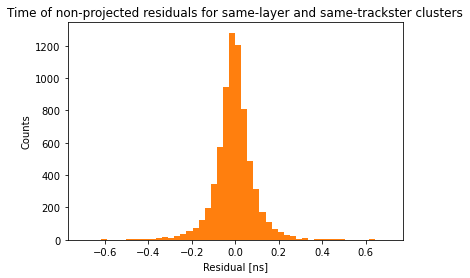

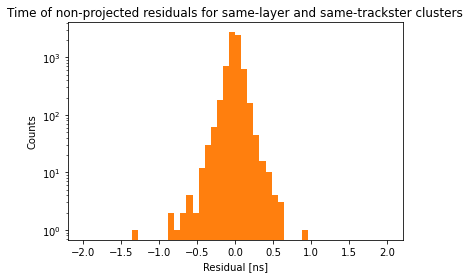

Info in <TCanvas::Print>: png file Plots/h2_nonproj_trackster.png has been created
Info in <TCanvas::Print>: pdf file Plots/h2_nonproj_trackster.pdf has been created
Info in <TCanvas::Print>: png file Plots/h2_nonproj_log_trackster.png has been created
Info in <TCanvas::Print>: pdf file Plots/h2_nonproj_log_trackster.pdf has been created


In [21]:
print(f_clusters.keys())

print(f_trackstersMerged.keys())


vertices_time=f_trackstersMerged["vertices_time"].array()
vertices_indexes=f_trackstersMerged["vertices_indexes"].array()

print(vertices_time)

print(vertices_indexes[0])

print([len(x) for x in vertices_time])




print(f_clusters["cluster_time"].array())
print(f_clusters["cluster_layer_id"].array())


cluster_time=f_clusters["cluster_time"].array()
cluster_energy=f_clusters["correctedEnergy"].array()
cluster_layer=f_clusters["cluster_layer_id"].array()
cluster_x=f_clusters['position_x'].array()
cluster_y=f_clusters['position_y'].array()
cluster_z=f_clusters['position_z'].array()
cluster_time_error=f_clusters["cluster_timeErr"].array()



print("cl_energy", type(cluster_energy))
n_elem= [len(x) for x in cluster_time]

#print("n_elem: ", n_elem)

time_residuals_nonproj=[]

'''
good=0
notgood=0
for i in range(len(n_elem)):
    
    for j in range(len(cluster_time[i])):
        if cluster_time[i][j]!=-99:
            good+=1
        else:
            notgood+=1

print("with time", good)
print("without time:", notgood)
print("percentage of clusters with time", good/(good+notgood))
'''
times_list=[]
nlayers=47
for i in range(nlayers):
    times_list.append([])

mask=(cluster_time!=-99)
#print(mask)

#ntimes=[len(x) for x in cluster_time]
#print("number of clusters:", ntimes)

cluster_time_clean=cluster_time[mask]
cluster_time_error_clean=cluster_time_error[mask]
cluster_energy_clean=cluster_energy[mask]
cluster_layer_clean=cluster_layer[mask]
cluster_x_clean=cluster_x[mask]
cluster_y_clean=cluster_y[mask]
cluster_z_clean=cluster_z[mask]
#print(len(cluster_time_clean))
#ntimes=[len(x) for x in cluster_time_clean]
#print(ntimes)
nlayers=47

file = ROOT.TFile.Open("Plots/plots_nonproj.root", "RECREATE")


res_layer=ROOT.TH2F("t_res","Time of non-projected residuals for same-layer and same-trackster clusters as a function of layer;Residual [ns];Layer",50,-1.,1.,nlayers,0.5,nlayers+0.5)
res_layer_sigma=ROOT.TH2F("t_res_sigma","Time residuals/error as a function of layer;Residual ;Layer",50,-3.,3.,nlayers,0.5,nlayers+0.5)

#mask_neg=(cluster_energy>100)
#print(cluster_energy[mask_neg])    

for i in tqdm(range(len(vertices_indexes))):
    for k in range(len(vertices_indexes[i])):
        mask_trackster=np.full((len(cluster_time[i])), False)
        for l in range(len(vertices_indexes[i][k])):
            mask_trackster[vertices_indexes[i][k][l]]=True
            
            
            
        mask_trackster=ak.Array(mask_trackster)
        #print(len(mask[i]), len(mask_trackster))
        mask_trackster_1=mask[i] & mask_trackster
        cluster_time_trackster=cluster_time[i][mask_trackster_1]
        cluster_time_error_trackster=cluster_time_error[i][mask_trackster_1]
        cluster_energy_trackster=cluster_energy[i][mask_trackster_1]
        cluster_layer_trackster=cluster_layer[i][mask_trackster_1]
        cluster_x_trackster=cluster_x[i][mask_trackster_1]
        cluster_y_trackster=cluster_y[i][mask_trackster_1]
        cluster_z_trackster=cluster_z[i][mask_trackster_1]
        
        
        
        
        for side in [-1.,1.]:
            mask_side_all=(side*cluster_z[i]>0)
            barycenter_z=compute_barycenter_z(cluster_energy[i][mask_side_all],cluster_z[i][mask_side_all])
            #print(barycenter_z)
            mask_side=(side*cluster_z_trackster>0)
            cluster_layer_side=cluster_layer_trackster[mask_side]
            cluster_time_side=cluster_time_trackster[mask_side]
            cluster_time_error_side=cluster_time_error_trackster[mask_side]
            cluster_x_side=cluster_x_trackster[mask_side]
            cluster_y_side=cluster_y_trackster[mask_side]
            cluster_z_side=cluster_z_trackster[mask_side]
            cluster_energy_side=cluster_energy_trackster[mask_side]
        
            for layer in range(nlayers):
                mask_layer=(cluster_layer_side==layer)
                cluster_time_layer=cluster_time_side[mask_layer]
                cluster_time_error_layer=cluster_time_error_side[mask_layer]
                cluster_energy_layer=cluster_energy_side[mask_layer]

                cluster_x_layer=cluster_x_side[mask_layer]
                cluster_y_layer=cluster_y_side[mask_layer]
                cluster_z_layer=cluster_z_side[mask_layer]

                if(len(cluster_energy_layer))>0:
                    max_idx=ak.argmax(cluster_energy_layer)
                    for j in range(len(cluster_energy_layer)):
                        if j!=max_idx:
                            #proj_pos_max=prop_to_bar([cluster_x_layer[max_idx],cluster_y_layer[max_idx],cluster_z_layer[max_idx]], barycenter_z)
                            #proj_time_max=cluster_time_layer[max_idx]+side*theta(barycenter_z-cluster_z_layer[max_idx])*distance(proj_pos_max[0],proj_pos_max[1],proj_pos_max[2],cluster_x_layer[max_idx],cluster_y_layer[max_idx],cluster_z_layer[max_idx])/C
                            #print(side*theta(barycenter_z-cluster_z_layer[max_idx])*distance(proj_pos_max[0],proj_pos_max[1],proj_pos_max[2],cluster_x_layer[max_idx],cluster_y_layer[max_idx],cluster_z_layer[max_idx])/C)

                            #proj_pos_j=prop_to_bar([cluster_x_layer[j],cluster_y_layer[j],cluster_z_layer[j]], barycenter_z)
                            #proj_time_j=cluster_time_layer[j]+side*theta(barycenter_z-cluster_z_layer[j])*distance(proj_pos_j[0],proj_pos_j[1],proj_pos_j[2],cluster_x_layer[j],cluster_y_layer[j],cluster_z_layer[j])/C
                            #print(side*theta(barycenter_z-cluster_z_layer[j])*distance(proj_pos_j[0],proj_pos_j[1],proj_pos_j[2],cluster_x_layer[j],cluster_y_layer[j],cluster_z_layer[j])/C)
                            
                            time_residuals_nonproj.append(cluster_time_layer[max_idx]-cluster_time_layer[j])
                            res_layer.Fill(cluster_time_layer[max_idx]-cluster_time_layer[j],layer)
                            #res_layer_sigma.Fill((cluster_time_layer[max_idx]-cluster_time_layer[j])/(cluster_time_error_layer[max_idx]**2+cluster_time_error_layer[j]**2)**0.5,layer)



ROOT.gStyle.SetOptStat(11);

c1=ROOT.TCanvas()
c1.cd()
res_layer.Draw("COLZ")
c1.SaveAs("Plots/h2_nonproj_trackster.png")
c1.SaveAs("Plots/h2_nonproj_trackster.pdf")

c1.Draw()

c1.SetLogz()
c1.Draw()
c1.SaveAs("Plots/h2_nonproj_log_trackster.png")

c1.SaveAs("Plots/h2_nonproj_log_trackster.pdf")


c1.Write()
res_layer.Write()
file.Close()
'''
c2=ROOT.TCanvas()
c2.cd()
res_layer_sigma.Draw("COLZ")
c2.SaveAs("h2_sigma.png")
c2.Draw()

c2.SetLogz()
c2.Draw()
c2.SaveAs("h2_sigma_log.png")
'''


plt.title("Time of non-projected residuals for same-layer and same-trackster clusters")
plt.xlabel("Residual [ns]")
plt.ylabel("Counts")
plt.hist(time_residuals_nonproj,bins=50, range=[-0.7,0.7],color="C1")

plt.savefig('Plots/h1_nonproj_trackster.pdf')  
plt.show() 

plt.title("Time of non-projected residuals for same-layer and same-trackster clusters")
plt.xlabel("Residual [ns]")
plt.ylabel("Counts")


plt.hist(time_residuals_nonproj,bins=50,log=True,range=[-2,2],color="C1")#, range=[0,0.1])
plt.savefig('Plots/h1_nonproj_log_trackster.pdf')  

plt.show() 





















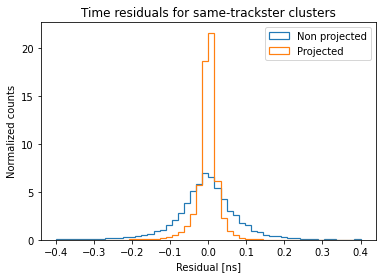

In [31]:

plt.title("Time residuals for same-trackster clusters")
plt.xlabel("Residual [ns]")
plt.ylabel("Normalized counts")
lw=1.2

plt.hist(time_residuals_nonproj,bins=50,log=False,range=[-0.4,0.4],histtype="step",label="Non projected",alpha=0.99,density=True,linewidth=lw)#, range=[0,0.1])
plt.hist(time_residuals_proj,bins=50,log=False,range=[-0.4,0.4],histtype="step",label="Projected",alpha=0.99,density=True,linewidth=lw)#, range=[0,0.1])

plt.legend()
plt.savefig('Plots/h1_nonproj_proj_comparison_trackster.pdf')  

plt.savefig('Plots/h1_nonproj_proj_comparison_log_trackster.png')  


In [ ]:
rechits_id = rechits["ID"].array()
rechits_energy = rechits["energy"].array()
rechits_eta = rechits["eta"].array()
rechits_pt = rechits_energy / np.cosh(rechits_eta)
rechits_son = rechits["signalOverNoise"].array()
rechits_time = rechits["time"].array()
rechits_timeError = rechits["time_error"].array()

In [ ]:
rh_eta = rechits_eta[np.logical_and(rechits_eta>0, rechits_son>3)]
rh_en = rechits_energy[np.logical_and(rechits_eta>0, rechits_son>3)]

In [ ]:
# plt.figure(dpi=100)
# myhist(ak.sum(rh_en, axis=1) / ak.flatten(CP_ene, axis=1), xlabel="Energy (GeV)", title="RH energy")
# plt.axvline(1, c="red")

In [ ]:
# check to see that no rechit id is there twice in an event
for ev in range(len(rechits_id)):
    if len(set(rechits_id[ev])) != len(rechits_id[ev]):
        print(ev)

In [ ]:
import ROOT
from matplotlib.gridspec import GridSpec

In [ ]:
# Create Matplotlib plot
fig = plt.figure(figsize = (10,8))

variable_name="time"
bins=30
minX = 1.7
maxX = 2.7

rechits_eta_filt = rechits_eta[rechits_son>3]
rechits_timeError_filt = rechits_timeError[rechits_son>3]

h_pass = ROOT.TH1F(f"hist_pass_{variable_name}", f"Passing {variable_name};{variable_name};Counts", bins, minX, maxX)
h_total = ROOT.TH1F(f"hist_total_{variable_name}", f"Total {variable_name};{variable_name};Counts", bins, minX, maxX)

# Fill histograms with numerator and denominator values
for variable_value in ak.flatten(rechits_eta_filt[np.logical_and(rechits_eta_filt>0, rechits_timeError_filt>0)]):
    h_pass.Fill(variable_value)

for variable_value in ak.flatten(rechits_eta_filt[rechits_eta_filt>0]):
    h_total.Fill(variable_value)

# Create a TEfficiency object using histograms
efficiency = ROOT.TEfficiency(h_pass, h_total)

# Extract efficiency points and errors
n_points = efficiency.GetTotalHistogram().GetNbinsX()
x_values = [efficiency.GetTotalHistogram().GetBinCenter(i) for i in range(1, n_points + 1)]
y_values = [efficiency.GetEfficiency(i) for i in range(1, n_points + 1)]
y_errors_low = [efficiency.GetEfficiencyErrorLow(i) for i in range(1, n_points + 1)]
y_errors_high = [efficiency.GetEfficiencyErrorUp(i) for i in range(1, n_points + 1)]

plt.errorbar(x_values, y_values, yerr=[y_errors_low, y_errors_high], fmt='o', label='Efficiency', capsize=2)


plt.xlim(minX, maxX)
plt.ylim(0, 1)
plt.xlabel("$\eta$", fontsize=20)
plt.ylabel("Efficiency", fontsize=20)
plt.title(r"fraction of hits with time vs $\eta$ (for $\eta$>0)", fontsize=22)
#plt.legend(fontsize=18)
plt.xticks(fontsize=18)
plt.xticks(fontsize=18)
plt.grid()
plt.show()

del h_pass, h_total

In [ ]:
np.savetxt("12fc_rechit_eta.txt", [x_values, y_values, y_errors_low, y_errors_high])

In [ ]:
fig = plt.figure(figsize = (10,8))

x_values, y_values, y_errors_low, y_errors_high = np.loadtxt("12fc_rechit_eta_son3.txt")
plt.errorbar(x_values, y_values, yerr=[y_errors_low, y_errors_high], fmt='s', capsize=2, color="dodgerblue", label="12 fC")
x_values, y_values, y_errors_low, y_errors_high = np.loadtxt("24fc_rechit_eta_son3.txt")
plt.errorbar(x_values, y_values, yerr=[y_errors_low, y_errors_high], fmt='s', capsize=2, color="purple", label="24 fC")

plt.xlim(minX, maxX)
plt.ylim(0, 1)
plt.xlabel("$\eta$", fontsize=20)
plt.ylabel("Efficiency", fontsize=20)
plt.title(r"fraction of hits with time vs $\eta$ (for $\eta$>0)", fontsize=22)
#plt.legend(fontsize=18)
plt.xticks(fontsize=18)
plt.xticks(fontsize=18)
plt.legend(fontsize=16)
plt.grid()
plt.show()

In [ ]:
# Create Matplotlib plot
fig = plt.figure(figsize = (18,10))

variable_name="time"
bins=30
mineta = [-3., 1.5]
maxeta = [-1.5, 3.]
gs = GridSpec(1, 2)

for k, (minX, maxX) in enumerate(zip(mineta, maxeta)):
    h_pass = ROOT.TH1F(f"hist_pass_{variable_name}", f"Passing {variable_name};{variable_name};Counts", bins, minX, maxX)
    h_total = ROOT.TH1F(f"hist_total_{variable_name}", f"Total {variable_name};{variable_name};Counts", bins, minX, maxX)

    sign = minX / abs(minX)
    # Fill histograms with numerator and denominator values
    for variable_value in ak.flatten(rechits_eta[np.logical_and(sign*rechits_eta>0, rechits_timeError>0)]):
        h_pass.Fill(variable_value)

    for variable_value in ak.flatten(rechits_eta[sign*rechits_eta>0]):
        h_total.Fill(variable_value)

    # Create a TEfficiency object using histograms
    efficiency = ROOT.TEfficiency(h_pass, h_total)

    # Extract efficiency points and errors
    n_points = efficiency.GetTotalHistogram().GetNbinsX()
    x_values = [efficiency.GetTotalHistogram().GetBinCenter(i) for i in range(1, n_points + 1)]
    y_values = [efficiency.GetEfficiency(i) for i in range(1, n_points + 1)]
    y_errors_low = [efficiency.GetEfficiencyErrorLow(i) for i in range(1, n_points + 1)]
    y_errors_high = [efficiency.GetEfficiencyErrorUp(i) for i in range(1, n_points + 1)]

    plt.subplot(gs[k])
    plt.errorbar(x_values, y_values, yerr=[y_errors_low, y_errors_high], fmt='o', label='Efficiency', capsize=2)

    plt.xlim(minX, maxX)
    plt.ylim(0, 1)
    plt.xlabel("eta", fontsize=20)
    plt.ylabel("efficiency", fontsize=20)
    if k == 1:
        plt.title("eta > 0", fontsize=22)
    else:
        plt.title("eta < 0", fontsize=22)
    del h_pass, h_total
plt.suptitle("fraction of hits with time vs eta", fontsize=22)
#plt.legend(fontsize=18)
plt.xticks(fontsize=18)
plt.xticks(fontsize=18)

plt.show()

In [ ]:
# Create Matplotlib plot
fig = plt.figure(figsize = (10,8))

variable_name="time"
bins=30
minX = 1.7
maxX = 2.7
minY = 0
maxY = 10

rechits_eta_filt = rechits_eta[rechits_son>3]
rechits_pt_filt = rechits_pt[rechits_son>3]
rechits_timeError_filt = rechits_timeError[rechits_son>3]

h_pass = ROOT.TH2F(f"hist_pass_{variable_name}", f"Passing {variable_name};{variable_name};Counts", bins, minX, maxX, bins, minY, maxY)
h_total = ROOT.TH2F(f"hist_total_{variable_name}", f"Total {variable_name};{variable_name};Counts", bins, minX, maxX, bins, minY, maxY)

# Fill histograms with numerator and denominator values
for v1, v2 in zip(ak.flatten(rechits_pt_filt[np.logical_and(rechits_eta_filt>0, rechits_timeError_filt>0)]), 
                  ak.flatten(rechits_eta_filt[np.logical_and(rechits_eta_filt>0, rechits_timeError_filt>0)])):
    h_pass.Fill(v2, v1)

for v1, v2 in zip(ak.flatten(rechits_pt_filt[rechits_eta_filt>0]), ak.flatten(rechits_eta_filt[rechits_eta_filt>0])):
    h_total.Fill(v2, v1)

# Create a TEfficiency object using histograms
efficiency = ROOT.TEfficiency(h_pass, h_total)
# Get the data points from TEfficiency
hist2D = efficiency.GetTotalHistogram()
num_bins_x = hist2D.GetNbinsX()
num_bins_y = hist2D.GetNbinsY()

x_values = []
y_values = []
efficiency_values = []

for i in range(1, num_bins_x + 1):
    for j in range(1, num_bins_y + 1):
        bin_content = hist2D.GetBinContent(i, j)
#         print(bin_content)

        x_values.append(hist2D.GetXaxis().GetBinCenter(i))
        y_values.append(hist2D.GetYaxis().GetBinCenter(j))
        efficiency_values.append(efficiency.GetEfficiency(hist2D.GetBin(i, j)))

# Convert lists to numpy arrays
x_values = np.array(x_values)
y_values = np.array(y_values)
efficiency_values = np.array(efficiency_values)
plt.figure(figsize=(10,8))
# Plot the scatter plot using Matplotlib
plt.scatter(x_values, y_values, c=efficiency_values, cmap='viridis', marker='o')
plt.colorbar(label='Efficiency')
plt.xlabel("$\eta$")
plt.ylabel("$p_T$")
plt.title('2D Efficiency Plot')

plt.show()

del h_pass, h_total

In [ ]:
aa=ak.flatten(rechits_energy[rechits_timeError==-1])
bb=ak.flatten(rechits_energy[np.logical_and(rechits_timeError!=-1, rechits_son>3)])
plt.figure(figsize=(10,8))
myhist(aa, bins=30, title=f"Energy of recHits without time\n({len(aa)} rechits, of which {len(aa[aa>0.05])} above 0.05 GeV)", xlabel="Energy(GeV)", range=(0.004,0.05))

In [ ]:
plt.figure(figsize=(10,8))
myhist(aa, bins=30, label="w/o time", title=f"Energy of recHits without time\n({len(aa)} rechits, of which {len(aa[aa>0.05])}\nabove 0.05GeV and {len(aa[aa>1])} over 3 GeV)", xlabel="Energy(GeV)", range=(0.05,3))
myhist(bb, bins=30,  label="w/ time", color="red", alpha = 0.5, title=f"RecHits energy\n({len(bb[bb<0.05])} w/ time and {len(aa[aa<0.05])} w/o time below 0.05 GeV\n{len(bb[bb>3])} w/ time and {len(aa[aa>3])} w/o time above 3 GeV)", xlabel="Energy(GeV)", range=(0.05,3))
plt.grid()
plt.text(1, 20000,f"{ak.count(rechits_energy[rechits_son>3])} rechits with S/N>3,\nof which {len(bb)} with time ({len(bb)/ak.count(rechits_energy[rechits_son>3])*100:.1f}%)", fontsize=18)
plt.legend(fontsize=18)
plt.show()

In [ ]:
cc=ak.flatten(rechits_timeError[np.logical_and(rechits_timeError!=-1, rechits_son>3)])
plt.figure(figsize=(10,8))
plt.scatter(bb, cc)
plt.grid()
plt.xlabel("Energy (GeV)")
plt.ylabel("Time error (ns)")
plt.ylim(0, 0.2)
plt.show()

## LCs

In [ ]:
simtrackstersSC = file["ticlDumper/simtrackstersSC"]
simtrackstersCP = file["ticlDumper/simtrackstersCP"]
tracksters  = file["ticlDumper/tracksters"]
trackstersMerged = file["ticlDumper/trackstersMerged"]
associations = file["ticlDumper/associations"]
# tracks = file["ticlDumper/tracks"]
# simTICLCandidate = file["ticlDumper/simTICLCandidate"]
# TICLCandidate = file["ticlDumper/candidates"]
clusters = file["ticlDumper/clusters"]

In [ ]:
trackstersMerged.keys()

In [ ]:
cluster_time = clusters["cluster_time"].array()
cluster_eta = clusters["position_eta"].array()
cluster_timeErr = clusters["cluster_timeErr"].array()
cluster_number_of_hits = clusters["cluster_number_of_hits"].array()
cluster_hits_with_time = clusters["cluster_number_of_hits_with_time"].array()
cluster_energy = clusters["energy"].array()

In [ ]:
SC_boundx        = simtrackstersSC["boundaryX"].array()
SC_boundy        = simtrackstersSC["boundaryY"].array()
SC_boundz        = simtrackstersSC["boundaryZ"].array()
SC_bx            = simtrackstersSC["barycenter_x"].array()
SC_by            = simtrackstersSC["barycenter_y"].array()
SC_bz            = simtrackstersSC["barycenter_z"].array()
SC_boundary_time = simtrackstersSC["timeBoundary"].array()
SC_CALO_time     = simtrackstersSC["time"].array()
SC_CALO_timeErr  = simtrackstersSC["timeError"].array()
SC_trackIdx      = simtrackstersSC["trackIdx"].array()
SC_vt            = simtrackstersSC["vertices_time"].array()
SC_vtErr         = simtrackstersSC["vertices_timeErr"].array()
SC_vi            = simtrackstersSC["vertices_indexes"].array()
SC_vx            = simtrackstersSC["vertices_x"].array()
SC_vy            = simtrackstersSC["vertices_y"].array()
SC_vz            = simtrackstersSC["vertices_z"].array()

In [ ]:
recoToSim_en    = associations["tsCLUE3D_recoToSim_SC_sharedE"].array()
recoToSim_score = associations["tsCLUE3D_recoToSim_SC_score"].array()
recoToSim_index = associations["tsCLUE3D_recoToSim_SC"].array()

simToReco_en    = associations["tsCLUE3D_simToReco_SC_sharedE"].array()
simToReco_score = associations["tsCLUE3D_simToReco_SC_score"].array()
simToReco_index = associations["tsCLUE3D_simToReco_SC"].array()

In [ ]:
ts_bx            = tracksters["barycenter_x"].array()
ts_by            = tracksters["barycenter_y"].array()
ts_bz            = tracksters["barycenter_z"].array()
ts_CALO_time     = tracksters["time"].array()
ts_CALO_timeErr  = tracksters["timeError"].array()
ts_vx            = tracksters["vertices_x"].array()
ts_vy            = tracksters["vertices_y"].array()
ts_vz            = tracksters["vertices_z"].array()
ts_vt            = tracksters["vertices_time"].array()
ts_energy        = tracksters["raw_energy"].array()
ts_vi            = tracksters["vertices_indexes"].array()

In [ ]:
tsMerge_vx  = trackstersMerged["vertices_x"].array()
tsMerge_vy  = trackstersMerged["vertices_y"].array()
tsMerge_vz  = trackstersMerged["vertices_z"].array()
tsMerge_vt  = trackstersMerged["vertices_time"].array()

## info on clusters

In [ ]:
plt.figure(figsize=(8,6))
myhist(ak.sum(ak.count(tsMerge_vz, axis=2), axis=1), title="Number of clusters per event", xlabel="# clusters")

In [ ]:
ev=7
id=0
plt.figure(figsize=(9,7))
myhist(tsMerge_vz[ev][id], bins=50, range=(ak.min(tsMerge_vz[ev][id]), ak.max(tsMerge_vz[ev][id])), 
       title=f"z of the clusters ({len(tsMerge_vz[ev][id])} in total, {len((tsMerge_vt[ev][id])[(tsMerge_vt[ev][id])>0])} with time)", xlabel="z (cm)")
myhist(tsMerge_vz[ev][id][(tsMerge_vt[ev][id])>0], bins=50, range=(ak.min(tsMerge_vz[ev][id]), ak.max(tsMerge_vz[ev][id])), 
       title=f"z of the clusters ({len(tsMerge_vz[ev][id])} in total, {len((tsMerge_vt[ev][id])[(tsMerge_vt[ev][id])>0])} with time)", xlabel="z (cm)", color="red", alpha=0.5)
plt.grid()
plt.show()

In [ ]:
scatter(tsMerge_vx[ev][id], tsMerge_vy[ev][id], title="clusters x-y plane", xlabel="x (cm)", ylabel="y (cm)")

In [ ]:
# Create Matplotlib plot
fig = plt.figure(figsize = (10,8))

variable_name="time"
bins=30
minX = 1.7
maxX = 2.7

h_pass = ROOT.TH1F(f"hist_pass_{variable_name}", f"Passing {variable_name};{variable_name};Counts", bins, minX, maxX)
h_total = ROOT.TH1F(f"hist_total_{variable_name}", f"Total {variable_name};{variable_name};Counts", bins, minX, maxX)

# Fill histograms with numerator and denominator values
for variable_value in ak.flatten(cluster_eta[np.logical_and(cluster_eta>0, cluster_timeErr>0)]):
    h_pass.Fill(variable_value)

for variable_value in ak.flatten(cluster_eta[cluster_eta>0]):
    h_total.Fill(variable_value)

# Create a TEfficiency object using histograms
efficiency = ROOT.TEfficiency(h_pass, h_total)

# Extract efficiency points and errors
n_points = efficiency.GetTotalHistogram().GetNbinsX()
x_values = [efficiency.GetTotalHistogram().GetBinCenter(i) for i in range(1, n_points + 1)]
y_values = [efficiency.GetEfficiency(i) for i in range(1, n_points + 1)]
y_errors_low = [efficiency.GetEfficiencyErrorLow(i) for i in range(1, n_points + 1)]
y_errors_high = [efficiency.GetEfficiencyErrorUp(i) for i in range(1, n_points + 1)]

# np.savetxt("24fc_3hit_lc_eta.txt", [x_values, y_values, y_errors_low, y_errors_high])
plt.errorbar(x_values, y_values, yerr=[y_errors_low, y_errors_high], fmt='o', label='Efficiency', capsize=2)

plt.xlim(minX, maxX)
plt.ylim(0, 1)
plt.xlabel("$\eta$", fontsize=20)
plt.ylabel("Efficiency", fontsize=20)
plt.title(r"fraction of LCs with time vs $\eta$ (for $\eta$>0)", fontsize=22)
#plt.legend(fontsize=18)
plt.xticks(fontsize=18)
plt.xticks(fontsize=18)
plt.grid()
plt.show()

del h_pass, h_total

In [ ]:
fig = plt.figure(figsize = (10,8))

x_values, y_values, y_errors_low, y_errors_high = np.loadtxt("12fc_1hit_lc_eta.txt")
plt.errorbar(x_values, y_values, yerr=[y_errors_low, y_errors_high], fmt='s', capsize=2, color="midnightblue", label="12 fC, 1 hit")
x_values, y_values, y_errors_low, y_errors_high = np.loadtxt("12fc_2hit_lc_eta.txt")
plt.errorbar(x_values, y_values, yerr=[y_errors_low, y_errors_high], fmt='s', capsize=2, color="forestgreen", label="12 fC, 2 hits")
x_values, y_values, y_errors_low, y_errors_high = np.loadtxt("12fc_3hit_lc_eta.txt")
plt.errorbar(x_values, y_values, yerr=[y_errors_low, y_errors_high], fmt='s', capsize=2, color="purple", label="12 fC, 3 hits")
x_values, y_values, y_errors_low, y_errors_high = np.loadtxt("24fc_1hit_lc_eta.txt")
plt.errorbar(x_values, y_values, yerr=[y_errors_low, y_errors_high], fmt='^', capsize=2, color="dodgerblue", label="24 fC, 1 hit")
x_values, y_values, y_errors_low, y_errors_high = np.loadtxt("24fc_2hit_lc_eta.txt")
plt.errorbar(x_values, y_values, yerr=[y_errors_low, y_errors_high], fmt='^', capsize=2, color="limegreen", label="24 fC, 2 hits")
x_values, y_values, y_errors_low, y_errors_high = np.loadtxt("24fc_3hit_lc_eta.txt")
plt.errorbar(x_values, y_values, yerr=[y_errors_low, y_errors_high], fmt='^', capsize=2, color="pink", label="24 fC, 3 hits")

plt.xlim(minX, maxX)
plt.ylim(0, 1)
plt.xlabel("$\eta$", fontsize=20)
plt.ylabel("Efficiency", fontsize=20)
plt.title(r"fraction of LCs with time vs $\eta$ (for $\eta$>0)", fontsize=22)
#plt.legend(fontsize=18)
plt.xticks(fontsize=18)
plt.xticks(fontsize=18)
plt.legend(fontsize=16)
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(ak.flatten(cluster_number_of_hits), range=(0,20),bins =20)
plt.grid()
plt.suptitle(str(ak.sum(cluster_number_of_hits>20))+ " clusters with more than 20 hits", y=0.95)
plt.title("Number of hits per cluster", y=1.1)
plt.xlabel("# hits per cluster")
plt.show()

In [ ]:
print("total number of LCs:", ak.count(cluster_number_of_hits))
print("number of 1 hit LCs:", ak.sum(ak.flatten(cluster_number_of_hits)==1))
print("number of 2 hit LCs:", ak.sum(ak.flatten(cluster_number_of_hits)==2))
print("number of 3 hit LCs:", ak.sum(ak.flatten(cluster_number_of_hits)==3))
print("number of >3 hit LCs:", ak.sum(ak.flatten(cluster_number_of_hits)>3))

In [ ]:
print("with time")
print("total number of LCs with time:", ak.count(cluster_number_of_hits[cluster_timeErr>0]))
print("number of 1 hit LCs with time:", ak.sum(ak.flatten(cluster_number_of_hits[cluster_timeErr>0])==1), f", {(ak.sum(ak.flatten(cluster_number_of_hits[cluster_timeErr>0])==1) / ak.sum(ak.flatten(cluster_number_of_hits)==1) *100):.2f}% of the clusters with 1 hits")
print("number of 2 hit LCs with time:", ak.sum(ak.flatten(cluster_number_of_hits[cluster_timeErr>0])==2), f", {(ak.sum(ak.flatten(cluster_number_of_hits[cluster_timeErr>0])==2) / ak.sum(ak.flatten(cluster_number_of_hits)==2) *100):.2f}% of the clusters with 2 hits")
print("number of 3 hit LCs with time:", ak.sum(ak.flatten(cluster_number_of_hits[cluster_timeErr>0])==3), f", {(ak.sum(ak.flatten(cluster_number_of_hits[cluster_timeErr>0])==3) / ak.sum(ak.flatten(cluster_number_of_hits)==3) *100):.2f}% of the clusters with 3 hits")
print("number of >3 hit LCs with time:", ak.sum(ak.flatten(cluster_number_of_hits[cluster_timeErr>0])>3), f", {(ak.sum(ak.flatten(cluster_number_of_hits[cluster_timeErr>0])>3) / ak.sum(ak.flatten(cluster_number_of_hits)>3) *100):.2f}% of the clusters with >3 hits")

In [ ]:
plt.figure(figsize=(10,8))
myhist(ak.flatten(cluster_energy[cluster_number_of_hits==1]), bins=40, label="1 hit", alpha=0.5, range=(0,5), density=True)
myhist(ak.flatten(cluster_energy[cluster_number_of_hits==2]), bins=40, label="2 hits", color="green", alpha=0.5, range=(0,5), density=True)
myhist(ak.flatten(cluster_energy[cluster_number_of_hits>=3]), bins=40, label="3 hits", color="red", alpha=0.5, range=(0,5), density=True)
plt.grid()
plt.title("Cluster energy")
plt.xlabel("Cluster energy (GeV)")
plt.legend(fontsize=18)
plt.show()

In [ ]:
plt.figure(figsize=(10,8))
myhist(ak.flatten(cluster_energy[cluster_number_of_hits==1]), bins=40, alpha=0.5, range=(0,1), density=True, label="1 hit")
myhist(ak.flatten(cluster_energy[cluster_number_of_hits==2])/2, bins=40, color="green", alpha=0.6, range=(0,1), density=True, label="2 hits")
myhist(ak.flatten(cluster_energy[cluster_number_of_hits>=3])/ak.flatten(cluster_number_of_hits[cluster_number_of_hits>=3]), bins=40, color="red", alpha=0.3, range=(0,1), density=True, label="3 hits")
plt.grid()
plt.title("Mean cluster energy per hit")
plt.xlabel("Cluster energy (GeV) / # of hits")
plt.legend(fontsize=18)
plt.show()

## simTracksters time validation

In [ ]:
## calcolo in vari modi che voglio il tmempo del trackster e poi propago sul tempo al boundary (c - retta) e vedo
## ha senso minimizzare la risoluzione e non la media? per il bias di c-retta
TIME = SC_CALO_time # ak.Array(time_all) #
deltaT = TIME[SC_boundary_time!=-99] - SC_boundary_time[SC_boundary_time!=-99]
deltaS = distance(SC_boundx[SC_boundary_time!=-99], SC_boundy[SC_boundary_time!=-99], SC_boundz[SC_boundary_time!=-99], 
                  SC_bx[SC_boundary_time!=-99], SC_by[SC_boundary_time!=-99], SC_bz[SC_boundary_time!=-99])
results = deltaT - deltaS / C

In [ ]:
plt.figure(figsize=(10,8))
resu = ak.flatten(results[results>-99]) #np.array(time_all)[np.array(time_all)>-99]
res, chi2 = gauss_fit_and_plot(resu, init_parms=[400,0,0.03], label="reco", bins=np.linspace(-0.3,0.3,50))
#plt.hist(resu)
plt.title("trackster time validation at boundary", y=1.1)
plt.suptitle(f"there are {ak.count(SC_CALO_timeErr)} simTrackstersSC, of which {ak.count(SC_CALO_timeErr[SC_CALO_timeErr>0])} with time", y=0.95)
plt.xlabel("time (ns)")
plt.ylabel("Counts / bin")
plt.legend(fontsize=16)
plt.show()

## recoTracksters time validation

In [ ]:
from numba import njit, prange

@njit 
def distance_numba(x1,y1,z1,x2,y2,z2):
    return ((x1-x2)**2+(y1-y2)**2+(z1-z2)**2)**0.5

@njit
def minNumba(arr):
    if len(arr) == 0:
        raise ValueError("argmin: array is empty")

    min_value = arr[0]

    for i in range(1, len(arr)):
        if arr[i] < min_value:
            min_value = arr[i]

    return min_value

@njit
def argminNumba(arr):
    if len(arr) == 0:
        raise ValueError("argmin: array is empty")

    min_index = 0
    min_value = arr[0]

    for i in range(1, len(arr)):
        if arr[i] < min_value:
            min_value = arr[i]
            min_index = i

    return min_index

In [ ]:
@njit
def compute_residui_r2s():
    residui=[]
    for ev in range(len(recoToSim_score)):
        recoToSim_en_ev = recoToSim_en[ev]
        recoToSim_score_ev = recoToSim_score[ev]
        recoToSim_index_ev = recoToSim_index[ev]
        ts_bx_ev = ts_bx[ev]
        ts_by_ev = ts_by[ev]
        ts_bz_ev = ts_bz[ev]
        ts_CALO_time_ev = ts_CALO_time[ev]
        ts_CALO_timeErr_ev = ts_CALO_timeErr[ev]
        for r2s_score, r2s_idx, bx, by, bz, t, tErr in zip(recoToSim_score_ev, recoToSim_index_ev, ts_bx_ev, ts_by_ev, ts_bz_ev, ts_CALO_time_ev, ts_CALO_timeErr_ev):
            si = r2s_idx[argminNumba(r2s_score)]
            boundx = SC_boundx[ev][si]        
            boundy = SC_boundy[ev][si]        
            boundz = SC_boundz[ev][si]                    
            boundt = SC_boundary_time[ev][si] 
            if min(r2s_score) < 0.35 and boundt != -99 and tErr > 0:
                deltaT = t - boundt
                deltaS = distance_numba(boundx, boundy, boundz, bx, by, bz)
                results = deltaT - deltaS / C
                residui.append(results)
    return residui

In [ ]:
@njit
def compute_residui_s2r():
    residui=[]
    for ev in range(len(simToReco_score)):
        simToReco_en_ev = simToReco_en[ev]
        simToReco_score_ev = simToReco_score[ev]
        simToReco_index_ev = simToReco_index[ev]
        boundx_ev = SC_boundx[ev]        
        boundy_ev = SC_boundy[ev]        
        boundz_ev = SC_boundz[ev]                    
        boundt_ev = SC_boundary_time[ev] 
        ts_bx_ev = ts_bx[ev]
        ts_by_ev = ts_by[ev]
        ts_bz_ev = ts_bz[ev]
        ts_time_ev = ts_CALO_time[ev]
        ts_timeErr_ev = ts_CALO_timeErr[ev]
        for s2r_score, s2r_idx, boundx, boundy, boundz, boundt in zip(simToReco_score_ev, simToReco_index_ev, boundx_ev, boundy_ev, boundz_ev, boundt_ev):
            ri = s2r_idx[argminNumba(s2r_score)]
            if min(s2r_score) < 0.35 and boundt != -99 and ts_timeErr_ev[ri] > 0:
                deltaT = ts_time_ev[ri] - boundt
                deltaS = distance_numba(boundx, boundy, boundz, ts_bx_ev[ri], ts_by_ev[ri], ts_bz_ev[ri])
                results = deltaT - deltaS / C
                residui.append(results)
    return residui

In [ ]:
plt.figure(figsize=(10,8))
res, chi2 = gauss_fit_and_plot(compute_residui_r2s(), init_parms=[400,0,0.03], label="reco", bins=np.linspace(-0.3,0.3,50))
#plt.hist(resu)
plt.title("trackster time validation at boundary r2s", y=1.1)
plt.suptitle(f"there are {ak.count(ts_CALO_timeErr)} reco tracksters, of which {ak.count(ts_CALO_timeErr[ts_CALO_timeErr>0])} with time", y=0.95)
plt.xlabel("time (ns)")
plt.ylabel("Counts / bin")
plt.legend(fontsize=16)
plt.show()

In [ ]:
plt.figure(figsize=(10,8))
res, chi2 = gauss_fit_and_plot(compute_residui_s2r(), init_parms=[400,0,0.03], label="reco", bins=np.linspace(-0.3,0.3,50))
#plt.hist(resu)
plt.title("trackster time validation at boundary s2r", y=1.1)
plt.suptitle(f"there are {ak.count(ts_CALO_timeErr)} reco tracksters, of which {ak.count(ts_CALO_timeErr[ts_CALO_timeErr>0])} with time", y=0.95)
plt.xlabel("time (ns)")
plt.ylabel("Counts / bin")
plt.legend(fontsize=16)
plt.show()

In [ ]:
# err = SC_CALO_timeErr #(?)
# results = results /err

# plt.figure(figsize=(10,7))
# resu = ak.flatten(results[results>-99]) #np.array(time_all)[np.array(time_all)>-99]
# res, chi2 = gauss_fit_and_plot(resu, init_parms=[30,0,1], label="reco", bins=np.linspace(-5,5,50))
# #plt.hist(resu)
# plt.title("trackster time validation at boundary")
# plt.xlabel("time (ns)")
# plt.ylabel("Counts / bin")
# plt.legend(fontsize=16)
# plt.show()

## recompute LC time

In [ ]:
from numba import njit, prange

@njit
def distance_numba(x1,y1,z1,x2,y2,z2):
    return ((x1-x2)**2+(y1-y2)**2+(z1-z2)**2)**0.5
@njit
def dot_numba(x, y):
    s = 0
    for i in range(len(x)):
        s += x[i]*y[i]
    return s

@njit
def project_lc_to_pca_numba(point, segment_start, segment_end):
    """
    `lc` is a 1D NumPy array of length 3 representing the point;
    `segment_start` and `segment_end` are 1D NumPy arrays of length 3 representing the start and end points of the line segment. 
    The function returns the minimum distance between the point and the line segment and the closest point on this segment.
    """
    segment_vector = segment_end - segment_start
    #print(segment_vector)
    point_vector = point - segment_start
    #print(point_vector)
    if not np.any(segment_vector):
        projection = 0
    else:
        projection = dot_numba(point_vector, segment_vector) / dot_numba(segment_vector, segment_vector)

    closest_point = segment_start + projection * segment_vector
    return np.linalg.norm(point - closest_point), closest_point

@njit(parallel=True)
def computeLCTime_numba(NMIN=3):
    MR=3
    time_all = []
    for ev in prange(len(SC_CALO_time)):
        time_ev = []
        for kk in prange(len(SC_vx[ev])):
            time_ts = 0
            n_ts = 0
            vx = SC_vx[ev][kk]
            vy = SC_vy[ev][kk]
            vz = SC_vz[ev][kk]
            vt = SC_vt[ev][kk]
        #     vx = vx[vt!=-99]
        #     vy = vy[vt!=-99]
        #     vz = vz[vt!=-99]
        #     vt = vt[vt!=-99]
            vi = SC_vi[ev][kk]
#             if nLCtime >= NMIN:
            for i, t in enumerate(vt):
                if t != -99 and project_lc_to_pca_numba(np.array([vx[i], vy[i], vz[i]]), np.array([0,0,0]), np.array([SC_bx[ev][kk], SC_by[ev][kk], SC_bz[ev][kk]]))[0] < MR:
        #             factor = ((vz[i]-CP_bz[ev][0])/abs(vz[i]-CP_bz[ev][0]))*(vz[i]/abs(vz[i]))
                    if abs(SC_bz[ev][kk])< abs(vz[i]):
                        time_ts += t - distance_numba(SC_bx[ev][kk], SC_by[ev][kk], SC_bz[ev][kk], vx[i], vy[i], vz[i])/C
                        n_ts+=1
                    else:
                        time_ts += t + distance_numba(SC_bx[ev][kk], SC_by[ev][kk], SC_bz[ev][kk], vx[i], vy[i], vz[i])/C
                        n_ts+=1
            if n_ts < NMIN:
                time_ev.append([-99.])
            else:
                time_ev.append([time_ts/n_ts])
        time_all.append(time_ev)
    return time_all

In [ ]:
def computeLCTime(NMIN=3):
    MR=3
    time_all = []
    for ev in range(len(SC_CALO_time)):
        time_ev = []
        for kk in range(len(SC_vx[ev])):
            time_ts = 0
            n_ts = 0
            vx = SC_vx[ev][kk]
            vy = SC_vy[ev][kk]
            vz = SC_vz[ev][kk]
            vt = SC_vt[ev][kk]
            vi = SC_vi[ev][kk]
            for i, t in enumerate(vt):
                if t != -99 and project_lc_to_pca(np.array([vx[i], vy[i], vz[i]]), np.array([0,0,0]), np.array([SC_bx[ev][kk], SC_by[ev][kk], SC_bz[ev][kk]]))[0] < MR:
                    if abs(SC_bz[ev][kk])< abs(vz[i]):
                        time_ts += t - distance(SC_bx[ev][kk], SC_by[ev][kk], SC_bz[ev][kk], vx[i], vy[i], vz[i])/C
                        n_ts+=1
                    else:
                        time_ts += t + distance(SC_bx[ev][kk], SC_by[ev][kk], SC_bz[ev][kk], vx[i], vy[i], vz[i])/C
                        n_ts+=1
            if n_ts < NMIN:
                time_ev.append(-99.)
            else:
                time_ev.append(time_ts/n_ts)
        time_all.append(time_ev)
    return time_all
    #print(n_ts, len(vt[vt!=-99]))

In [ ]:
time_all = computeLCTime(4) #e_numba

In [ ]:
## calcolo in vari modi che voglio il tmempo del trackster e poi propago sul tempo al boundary (c - retta) e vedo
## ha senso minimizzare la risoluzione e non la media? per il bias di c-retta
TIME =  ak.Array(time_all) #
deltaT = TIME[SC_boundary_time!=-99] - SC_boundary_time[SC_boundary_time!=-99]
deltaS = distance(SC_boundx[SC_boundary_time!=-99], SC_boundy[SC_boundary_time!=-99], SC_boundz[SC_boundary_time!=-99], 
                  SC_bx[SC_boundary_time!=-99], SC_by[SC_boundary_time!=-99], SC_bz[SC_boundary_time!=-99])
results = deltaT - deltaS / C

In [ ]:
plt.figure(figsize=(10,8))
resu = ak.flatten(results[results>-99]) #np.array(time_all)[np.array(time_all)>-99]
res, chi2 = gauss_fit_and_plot(resu, init_parms=[30,0,0.03], label="reco", bins=np.linspace(-0.3,0.3,50))
#plt.hist(resu)
plt.title("trackster time validation at boundary", y=1.1)
plt.suptitle(f"there are {ak.count(SC_CALO_timeErr)} simTrackstersSC, of which {ak.count(TIME[TIME>0])} with time", y=0.95)
plt.xlabel("time (ns)")
plt.ylabel("Counts / bin")
plt.legend(fontsize=16)
plt.show()

In [ ]:
@njit
def computeCaloTime_numba(ev, vx, vy, vz, vt, vi, LChitTime, bx, by, bz, NMIN =3, MR=3):
    n_ts = 0
    time_ts = 0
    for i, t in enumerate(vt):
        nHitsWithTime = LChitTime[vi[i]]
        if t != -99 and project_lc_to_pca_numba(np.array([vx[i], vy[i], vz[i]]), np.array([0.,0.,0.]), np.array([bx, by, bz]))[0] < MR and nHitsWithTime >= NMIN:
            n_ts+=1
            if np.abs(bz) < np.abs(vz[i]):
                time_ts += t - distance_numba(bx, by, bz, vx[i], vy[i], vz[i])/C
            else:
                time_ts += t + distance_numba(bx, by, bz, vx[i], vy[i], vz[i])/C
    if n_ts == 0:
        return -99.
    else:
        return time_ts/n_ts
    return -99.

In [ ]:
@njit
def compute_res_r2s(NMIN = 3):
    residui=[]
    for ev in range(len(recoToSim_score)):
        recoToSim_en_ev = recoToSim_en[ev]
        recoToSim_score_ev = recoToSim_score[ev]
        recoToSim_index_ev = recoToSim_index[ev]
        ts_bx_ev = ts_bx[ev]
        ts_by_ev = ts_by[ev]
        ts_bz_ev = ts_bz[ev]
        ts_vx_ev = ts_vx[ev]
        ts_vy_ev = ts_vy[ev]
        ts_vz_ev = ts_vz[ev]
        ts_vt_ev = ts_vt[ev]
        ts_vi_ev = ts_vi[ev]
        LChitTime = cluster_hits_with_time[ev]
        for r2s_score, r2s_idx, bx, by, bz, vx, vy, vz, vt, vi in zip(recoToSim_score_ev, recoToSim_index_ev, ts_bx_ev, ts_by_ev, ts_bz_ev, ts_vx_ev, ts_vy_ev, ts_vz_ev, ts_vt_ev, ts_vi_ev):
            t = computeCaloTime_numba(ev, vx, vy, vz, vt, vi, LChitTime, bx, by, bz, NMIN)
            si = r2s_idx[argminNumba(r2s_score)]
            boundt = SC_boundary_time[ev][si]
            if minNumba(r2s_score) < 0.35 and boundt != -99 and t != -99:
                boundx = SC_boundx[ev][si]
                boundy = SC_boundy[ev][si]
                boundz = SC_boundz[ev][si]
                deltaT = t - boundt
                deltaS = distance_numba(boundx, boundy, boundz, bx, by, bz)
                results = deltaT - deltaS / C
                residui.append(results)
    return residui

In [ ]:
plt.figure(figsize=(10,8))
nHits = 3
resu=compute_res_r2s(nHits)
res, chi2 = gauss_fit_and_plot(resu, init_parms=[400,0,0.03], label="reco", bins=np.linspace(-0.3,0.3,50))
#plt.hist(resu)
plt.title(f"CLUE3Dts time validation at boundary (min {nHits} hits with time)", y=1.05)
plt.suptitle(f"there are {ak.count(ts_CALO_timeErr)} reco tracksters, of which {len(resu)} with time", y=0.91)
plt.xlabel("time (ns)")
plt.ylabel("Counts / bin")
plt.legend(fontsize=16)
plt.show()

In [ ]:
scan_n_ts = []
scan_sigma = []
scan_err = []
for nHits in [2,3,4,5,6,7,8,9,10]:
    resu=compute_res_r2s(nHits)
    res, chi2, _, _ = gauss_fit(resu, init_parms=[400,0,0.03], bins=np.linspace(-0.3,0.3,50))
    scan_n_ts.append(len(resu))
    scan_sigma.append(res.values[2])
    scan_err.append(res.errors[2])

np.savetxt("ts_with_time_vs_res_24fC.txt", [scan_n_ts, scan_sigma, scan_err])

In [ ]:
scan_12 = np.loadtxt("ts_with_time_vs_res_12fC.txt")
scan_24 = np.loadtxt("ts_with_time_vs_res_24fC.txt")
plt.figure(figsize=(10,8))
plt.errorbar(scan_12[0], scan_12[1], scan_12[2], fmt='^', capsize=5, markersize=10, label="12 fC")
plt.errorbar(scan_24[0], scan_24[1], scan_24[2], fmt='^', capsize=5, markersize=10, label="24 fC")
#plt.hist(resu)
plt.title(f"# CLUE3Dts with time VS $\sigma$ from the residual fit")
# plt.suptitle(f"there are {ak.count(ts_CALO_timeErr)} reco tracksters, of which {len(resu)} with time", y=0.91)
plt.xlabel("# tracksters with time", fontsize=18)
plt.ylabel("time resolution (ns)", fontsize=18)
plt.legend(fontsize=16)
plt.grid()
plt.show()

In [ ]:
# usare il quantile sulle y
scan_n_ts = []
scan_sigma = []
for nHits in np.arange(2,20):
    resu=compute_res_r2s(nHits)
    scan_n_ts.append(len(resu))
    scan_sigma.append(np.quantile(resu, 0.75) - np.quantile(resu, 0.25))

np.savetxt("ts_with_time_vs_quant_24fC_test.txt", [scan_n_ts, scan_sigma])

In [ ]:
# scan_12 = np.loadtxt("ts_with_time_vs_res_12fC.txt")
scan_12_q = np.loadtxt("ts_with_time_vs_quant_12fC.txt")
scan_24_q = np.loadtxt("ts_with_time_vs_quant_24fC.txt")
plt.figure(figsize=(10,8))
plt.scatter(scan_12_q[0], scan_12_q[1], marker='^', s=70, label="12 fC")
plt.scatter(scan_24_q[0], scan_24_q[1], marker='^', s=70, label="24 fC")
for i, nHits in enumerate(np.arange(2,11)):
    plt.text(scan_12_q[0][i], scan_12_q[1][i], s="\n "+str(nHits), fontsize=18)
    plt.text(scan_24_q[0][i], scan_24_q[1][i], s="\n "+str(nHits), fontsize=18)
#plt.hist(resu)
plt.title(f"# CLUE3Dts with time VS quantile (0.25-0.75)")
# plt.suptitle(f"there are {ak.count(ts_CALO_timeErr)} reco tracksters, of which {len(resu)} with time", y=0.91)
plt.xlabel("# tracksters with time", fontsize=18)
plt.ylabel("quantile", fontsize=18)
plt.legend(fontsize=16)
plt.grid()
plt.show()

In [ ]:
# scan_12 = np.loadtxt("ts_with_time_vs_res_12fC.txt")
scan_12_q = np.loadtxt("ts_with_time_vs_quant_12fC_test.txt")
scan_24_q = np.loadtxt("ts_with_time_vs_quant_24fC_test.txt")
plt.figure(figsize=(10,8))
plt.scatter(scan_12_q[0][4:], scan_12_q[1][4:], marker='^', s=70, label="12 fC")
plt.scatter(scan_24_q[0][2:], scan_24_q[1][2:], marker='^', s=70, label="24 fC")
for i, nHits in enumerate(np.arange(4,20)):
    plt.text(scan_24_q[0][2:][i], scan_24_q[1][2:][i], s="\n "+str(nHits), fontsize=18)
for i, nHits in enumerate(np.arange(6,20)):
    plt.text(scan_12_q[0][4:][i], scan_12_q[1][4:][i], s="\n "+str(nHits), fontsize=18)
#plt.hist(resu)
plt.title(f"# CLUE3Dts with time VS quantile (0.25-0.75)")
# plt.suptitle(f"there are {ak.count(ts_CALO_timeErr)} reco tracksters, of which {len(resu)} with time", y=0.91)
plt.xlabel("# tracksters with time", fontsize=18)
plt.ylabel("quantile", fontsize=18)
plt.legend(fontsize=16)
plt.grid()
plt.show()

## energy distribution of tracksters with time

In [ ]:
@njit
def energy_with_time(NMIN = 3):
    energy=[]
    for ev in range(len(recoToSim_score)):
        recoToSim_en_ev = recoToSim_en[ev]
        recoToSim_score_ev = recoToSim_score[ev]
        recoToSim_index_ev = recoToSim_index[ev]
        ts_bx_ev = ts_bx[ev]
        ts_by_ev = ts_by[ev]
        ts_bz_ev = ts_bz[ev]
        ts_vx_ev = ts_vx[ev]
        ts_vy_ev = ts_vy[ev]
        ts_vz_ev = ts_vz[ev]
        ts_vt_ev = ts_vt[ev]
        ts_vi_ev = ts_vi[ev]
        ts_en_ev = ts_energy[ev]
        LChitTime = cluster_hits_with_time[ev]
        for r2s_score, r2s_idx, bx, by, bz, vx, vy, vz, vt, vi, en in zip(recoToSim_score_ev, recoToSim_index_ev, ts_bx_ev, ts_by_ev, ts_bz_ev, ts_vx_ev, ts_vy_ev, ts_vz_ev, ts_vt_ev, ts_vi_ev, ts_en_ev):
            t = computeCaloTime_numba(ev, vx, vy, vz, vt, vi, LChitTime, bx, by, bz, NMIN)
            si = r2s_idx[argminNumba(r2s_score)]
            if minNumba(r2s_score) < 0.35 and t != -99:
                energy.append(en)
    return energy

In [ ]:
plt.figure(figsize=(10,8))
for nHits in range(2,11,2):
    plt.hist(energy_with_time(nHits), label=str(nHits), alpha=0.5, bins=30, range=(0,50))
plt.title(f"energy distribution of CLUE3Dts with time")
plt.xlabel("Energy (GeV)")
plt.ylabel("Counts / bin (log scale)")
plt.legend(fontsize=16)
plt.yscale("log")
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(10,8))
for nHits in range(2,11,2):
    plt.hist(energy_with_time(nHits), label=str(nHits), alpha=0.5, bins=30, range=(0,50))
plt.title(f"energy distribution of CLUE3Dts with time")
plt.xlabel("Energy (GeV)")
plt.ylabel("Counts / bin")
plt.legend(fontsize=16)
plt.grid()
plt.show()

In [ ]:
#TODO
#-energy fraction
#-pt 10 eta 1.7 e poi 2.5

## use fraction of energy

In [ ]:
tot_ts_en = ak.sum(ts_energy, axis=1)
tot_LC_en = ak.sum(cluster_energy, axis=1)

In [ ]:
@njit
def energy_frac_with_time(NMIN = 3):
    energy=[]
    for ev in range(len(recoToSim_score)):
        recoToSim_en_ev = recoToSim_en[ev]
        recoToSim_score_ev = recoToSim_score[ev]
        recoToSim_index_ev = recoToSim_index[ev]
        ts_bx_ev = ts_bx[ev]
        ts_by_ev = ts_by[ev]
        ts_bz_ev = ts_bz[ev]
        ts_vx_ev = ts_vx[ev]
        ts_vy_ev = ts_vy[ev]
        ts_vz_ev = ts_vz[ev]
        ts_vt_ev = ts_vt[ev]
        ts_vi_ev = ts_vi[ev]
        ts_en_ev = ts_energy[ev]
        LChitTime = cluster_hits_with_time[ev]
        for r2s_score, r2s_idx, bx, by, bz, vx, vy, vz, vt, vi, en in zip(recoToSim_score_ev, recoToSim_index_ev, ts_bx_ev, ts_by_ev, ts_bz_ev, ts_vx_ev, ts_vy_ev, ts_vz_ev, ts_vt_ev, ts_vi_ev, ts_en_ev):
            t = computeCaloTime_numba(ev, vx, vy, vz, vt, vi, LChitTime, bx, by, bz, NMIN)
            si = r2s_idx[argminNumba(r2s_score)]
            if minNumba(r2s_score) < 0.35 and t != -99:
                energy.append(en / tot_ts_en[ev])
    return energy

In [ ]:
plt.figure(figsize=(10,8))
for nHits in range(2,11,2):
    plt.hist(energy_frac_with_time(nHits), label=str(nHits), alpha=0.5, bins=30, range=(0,1))
plt.title(f"energy distribution of CLUE3Dts with time")
plt.xlabel("ts energy / all ts energy")
plt.ylabel("Counts / bin (log scale)")
plt.legend(fontsize=16)
plt.yscale("log")
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(10,8))
for nHits in range(2,11,2):
    plt.hist(energy_frac_with_time(nHits), label=str(nHits), alpha=0.5, bins=30, range=(0,1))
plt.title(f"energy distribution of CLUE3Dts with time")
plt.xlabel("ts energy / all ts energy")
plt.ylabel("Counts / bin")
plt.legend(fontsize=16)
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(10,8))
plt.hist(ak.flatten(ts_energy), bins=30)
plt.title(f"energy distribution of CLUE3Dts")
plt.xlabel("Energy (GeV)")
plt.ylabel("Counts / bin (log scale)")
# plt.legend(fontsize=16)
plt.yscale("log")
plt.grid()
plt.show()

## 2D plot of fraction vs energy

In [ ]:
@njit
def energy_2d_with_time(NMIN = 3):
    energy=[]
    for ev in range(len(recoToSim_score)):
        recoToSim_en_ev = recoToSim_en[ev]
        recoToSim_score_ev = recoToSim_score[ev]
        recoToSim_index_ev = recoToSim_index[ev]
        ts_bx_ev = ts_bx[ev]
        ts_by_ev = ts_by[ev]
        ts_bz_ev = ts_bz[ev]
        ts_vx_ev = ts_vx[ev]
        ts_vy_ev = ts_vy[ev]
        ts_vz_ev = ts_vz[ev]
        ts_vt_ev = ts_vt[ev]
        ts_vi_ev = ts_vi[ev]
        ts_en_ev = ts_energy[ev]
        LChitTime = cluster_hits_with_time[ev]
        for r2s_score, r2s_idx, bx, by, bz, vx, vy, vz, vt, vi, en in zip(recoToSim_score_ev, recoToSim_index_ev, ts_bx_ev, ts_by_ev, ts_bz_ev, ts_vx_ev, ts_vy_ev, ts_vz_ev, ts_vt_ev, ts_vi_ev, ts_en_ev):
            t = computeCaloTime_numba(ev, vx, vy, vz, vt, vi, LChitTime, bx, by, bz, NMIN)
            si = r2s_idx[argminNumba(r2s_score)]
            if minNumba(r2s_score) < 0.35 and t != -99:
                energy.append([en / tot_ts_en[ev], en])
    return energy

In [ ]:
plt.figure(figsize=(10,8))
frac, en = np.array(energy_2d_with_time(10)).T
plt.hist2d(frac, en, bins=50, cmap="hot_r")
plt.title(f"CLUE3Dts with > 10 hits with time - fixed eta/pt")
plt.xlabel("ts energy / all LC energy")
plt.ylabel("Energy (GeV)")
# plt.xscale("log")
# plt.yscale("log")
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(10,8))
plt.hist(ak.flatten(ts_energy / tot_LC_en), bins=30)
plt.title(f"energy distribution of CLUE3Dts")
plt.xlabel("Energy (GeV)")
plt.ylabel("Counts / bin (log scale)")
# plt.legend(fontsize=16)
# plt.yscale("log")
plt.grid()
plt.show()

In [ ]:
len(ts_energy)